In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
import sys
sys.path.insert(0,"..")
from predict.prediction_batch import greedy_decode_batch
from predict.prediction_string import decode_seq_str, decode_interacively
import pdb
from model.loss import LossCompute
import os
from io_.info_print import printing
from model.seq2seq import LexNormalizer
from model.generator import Generator
from evaluate.interact import interact
MAX_LEN = 100
script_dir = "."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
#model_folder_starts_with = "f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04"
#model_folder_starts_with = "f178-DROPOUT_EVEN_INCREASE-0.1-to_sent+word+bridge_out-model_3_046c"
#model_folder_starts_with = "8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout0.1_scale_aux-True_aux-0.1do_char_dec-True_char_src_atten-model_14_ad6c"
#model_folder_starts_with = "a5c77"
#model_folder_starts_with = "fef8-new_data-batchXdropout_char0-to_char_src-1_dir_sent-10_batch_size-model_2_51a5"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3"
#model_folder_starts_with ="8ce6b"
#model_folder_starts_with = "8e628"
#model_folder_starts_with = "84736"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-True_char_src_atten-model_10_b59b"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-False_char_src_atten-model_9_bb70"
model_folder_starts_with = "b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05"
#model_folder_starts_with = "97068_rioc-b91d7-aux-again-biggerREPLICATE-replicate1-2dir_word-None_aux-model_19_fb56"
#model_folder_starts_with = "97079_rioc-ef365-ATTbest-scale-2-True-25dir_word_encoder-all_context-att2-model_1_cade"
#model_folder_starts_with = "97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_word-stable_decod-init_con_False-teacher_forceprop10_True-model_4_c551"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_all-stable_decod-init_con_False-teacher_forceprop10_True-model_2_7673"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_False-model_6_c253-folder"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_True-model_5_72ee-folder"
model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
model_folder_starts_with = "97679_rioc--ATTmodel_10-model_10_b22f-folder"
model_folder_starts_with = "4e128-WARMUP-unrolling-False0-model_1-model_1_1660-folder"
model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_3-model_3_88a4-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_1-model_1_413f-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_2-model_2_7a98"
model_folder_starts_with = "97793_rioc--DEBUG_NO_LOSS_PADDING-2LSMT-2dense0-model_1-model_1_b872-folder"
model_folder_starts_with = "97823_rioc--DEBUG_NO_LOSS_PADDING-LEAKY-2LSMT-2dense-5DROPOUT00-model_1-model_1_60d8-folder"


# model word context char decode no attn 
#model_folder_starts_with = "97942_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_767d-folder"
model_folder_starts_with = "98349_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_6249-folder"
model_folder_starts_with = "98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder"
#model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-start_3_ep-X1-train_longer"
model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder"
#"98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
model_folder_starts_with = "99733_rioc--DEBUG_NO_LOSS_PADDING-0-model_3-model_3_ccda-folder"
model_folder_starts_with =  "99731_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_6cf0-folder"
#model_folder_starts_with = "99733_rioc--DEBUG_NO_LOSS_PADDING-0-model_4-model_4_5ce2-folder"
model_folder_starts_with = "100147_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8b89-folder"
# fake words only char2char
#model_folder_starts_with = "EU"
model_folder_starts_with = "9096728-B0-model_1-model_1_59a7-folder"
model_folder_starts_with = "9096728-B0-model_2-model_2_375c-folder"

In [33]:
# list all models folder that starts with model_folder_starts_with
list_all_dir = os.listdir("../checkpoints/")
list_ = [dir_ for dir_ in list_all_dir if dir_.startswith(model_folder_starts_with) and not dir_.endswith("log") and not dir_.endswith("summary")]
print(list_)

['9096728-B0-model_2-model_2_375c-folder']


### Model to interact with 

#### Former models : trained on Liu only , source added as concatanation of word and sentence level as h_0 of decoder , batch size = 10 , small drop out , 

- f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04 : very bad at interacting (NB ; pb of eval)
- f178 also good model trained on liu only 
- 8e628 : attention ; no aux (no bucket , get_batch False ) :  - attention degrades abit the results (still feedin char embedding also)
- e390 + same 24f94 goo : 
    - best is e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2 
    - same with attentin but lame : e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3f (have to do some code for reloading and visulizing !)

#### New data 
- fef8_new_data : 
- mixed data+ aix test :  8d9a0 + b9e49 to compare bucketing impact at train time 
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-norm.html
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8d9a0-auxiililary_true_false.html
    
    
- Auxilliary tuning : best model : b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05-folderfile:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-enriched-auxilliary_task_norm_not_norm-dense_dim_view.html
-

#### Last two ablations with extending epoch + mix data + ablation on auxilliary task ponderation + attention or not  

- 8ce6b-extend_ep... 
    - super lame attention model (from ablation with all context)
    - the other one a bit better   
- a5c77 a bit better but still : no attention much better : cf. plot 

#### Smaller model + liu only 
- 84736 smaller model: still waiting for models : attention not helping 

NB : attention makes training 10 times slower  

In [34]:
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis.html # f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_norm_view.html #f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_2.html # f178 + aaad 

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-data_view.html
# -- 
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html
##file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-iterate+new_data-norm_view.html (different results with below ? get_batch due ?? )
##/Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html 
## diffent from file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html val True 
#--

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/liu-attention+unrolling-more-param.html #e390
#!open file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/e390_best+24f9d-VAL_FALSE.html (e390 with Vale False 10 points above!! )

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/fef8_new_data.html (very good ?)

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/extend_ep-SENT_context-get_True-attention_simplifiedXauxXdropout-last+bucket_False_eval-get_batch_False.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8e628-no_bucketing-get_batch_False-train-attention-last+bucket_False_eval-get_batch_False-report.json.html



--------------------------------Interatcing with new model--------------------------------
 9096728-B0-model_2-model_2_375c 


Loading dictionary from ./../checkpoints/9096728-B0-model_2-model_2_375c-folder/dictionaries 
Loading model with argument {'hidden_size_decoder': 200, 'voc_size': 486, 'weight_pos_loss': 0, 'tasks_schedule_policy': None, 'symbolic_root': True, 'decoder_arch': {'stable_decoding_state': False, 'word_decoding': 0, 'unrolling_word': 1, 'drop_out_word_decoder_cell': 0.3, 'char_src_attention': 1, 'activation_word_decoder': 'nn.LeakyReLU', 'drop_out_bridge': 0.0, 'activation_char_decoder': 'nn.LeakyReLU', 'cell_word': 'LSTM', 'init_context_decoder': True, 'char_decoding': True, ' ce': 1, 'dense_dim_word_pred_2': None, 'dense_dim_word_pred_3': None, 'drop_out_char_embedding_decoder': 0.3, 'dir_word': 'uni', 'dense_dim_word_pred': None, 'teacher_force': 1, 'cell_sentence': 'none'}, 'shared_context': 'word', 'word_voc_input_size': 20001, 'hidden_size_encoder': 400, 'sy

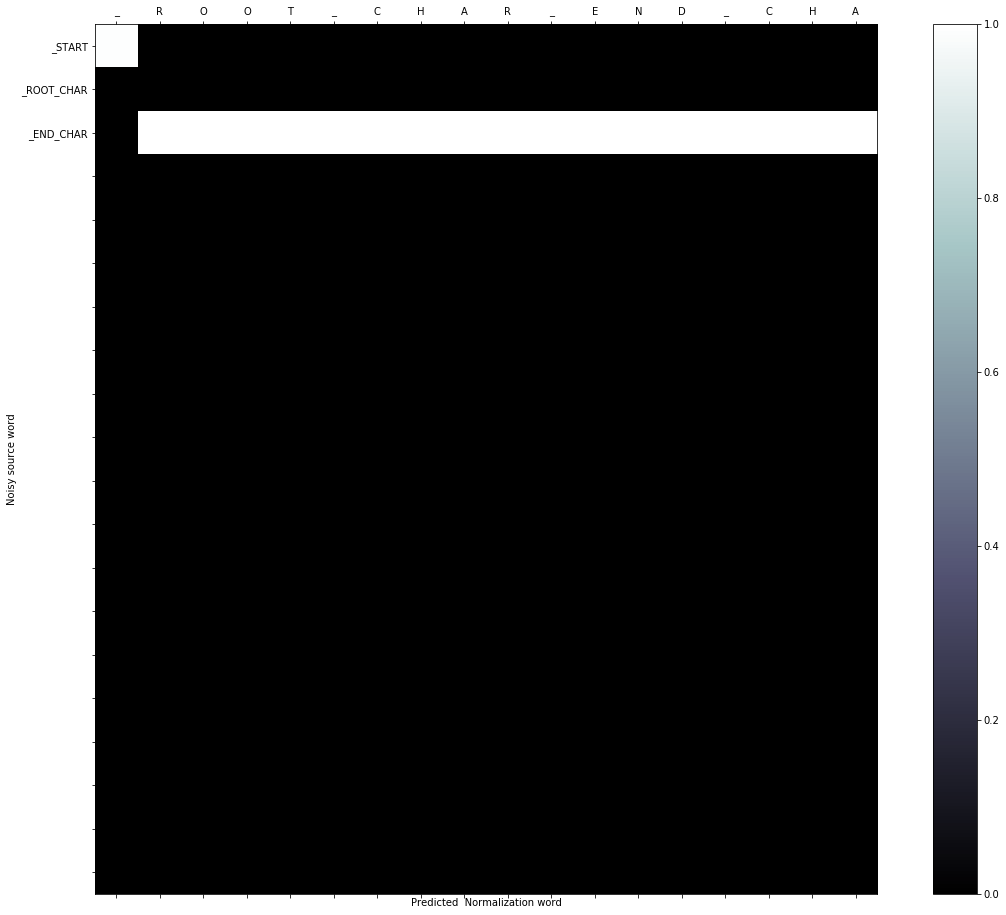

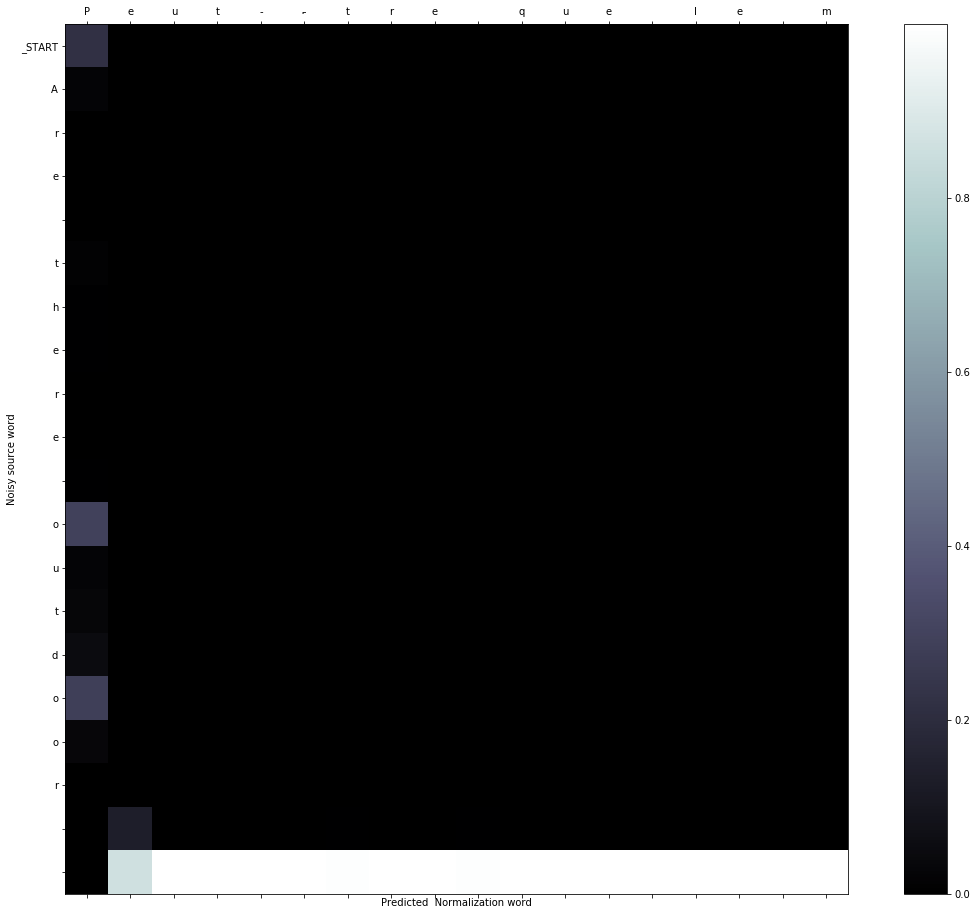

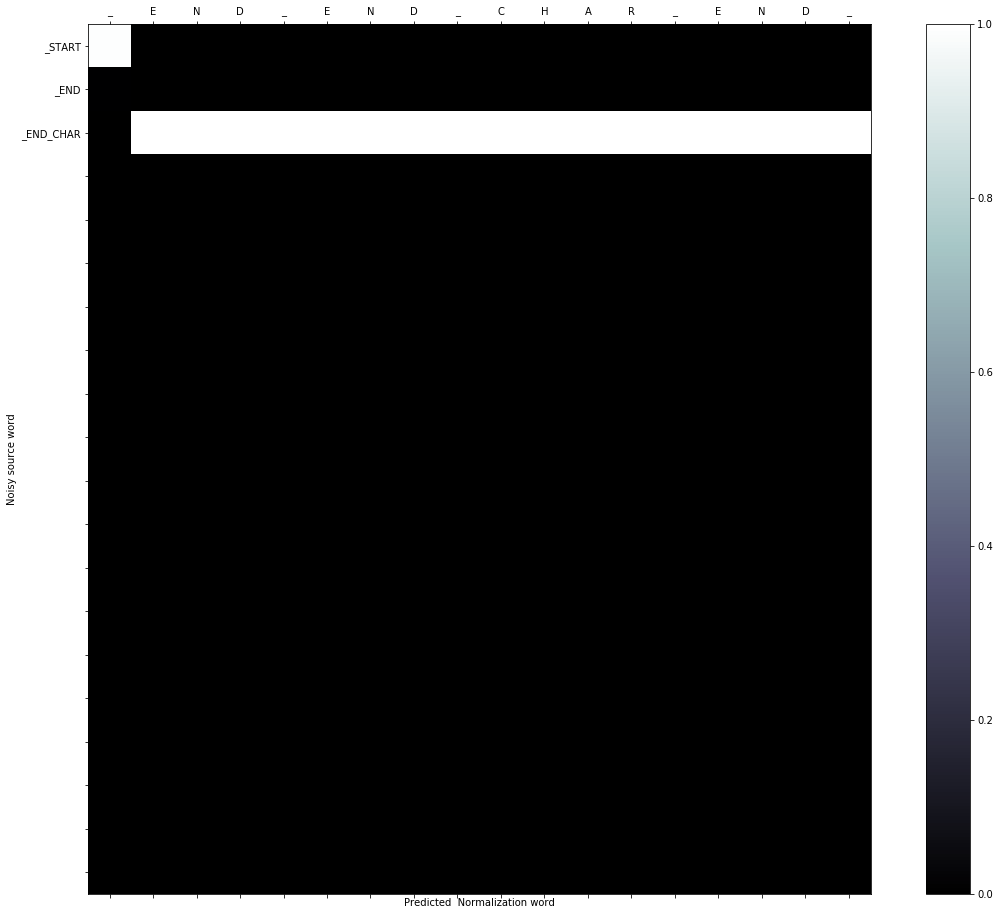

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Peut-être que le m', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre there outdoor ', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    A revolver can one shot someone who doesn't have a shield.
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ["A revolver can one shot someone who doesn't have a shield."]


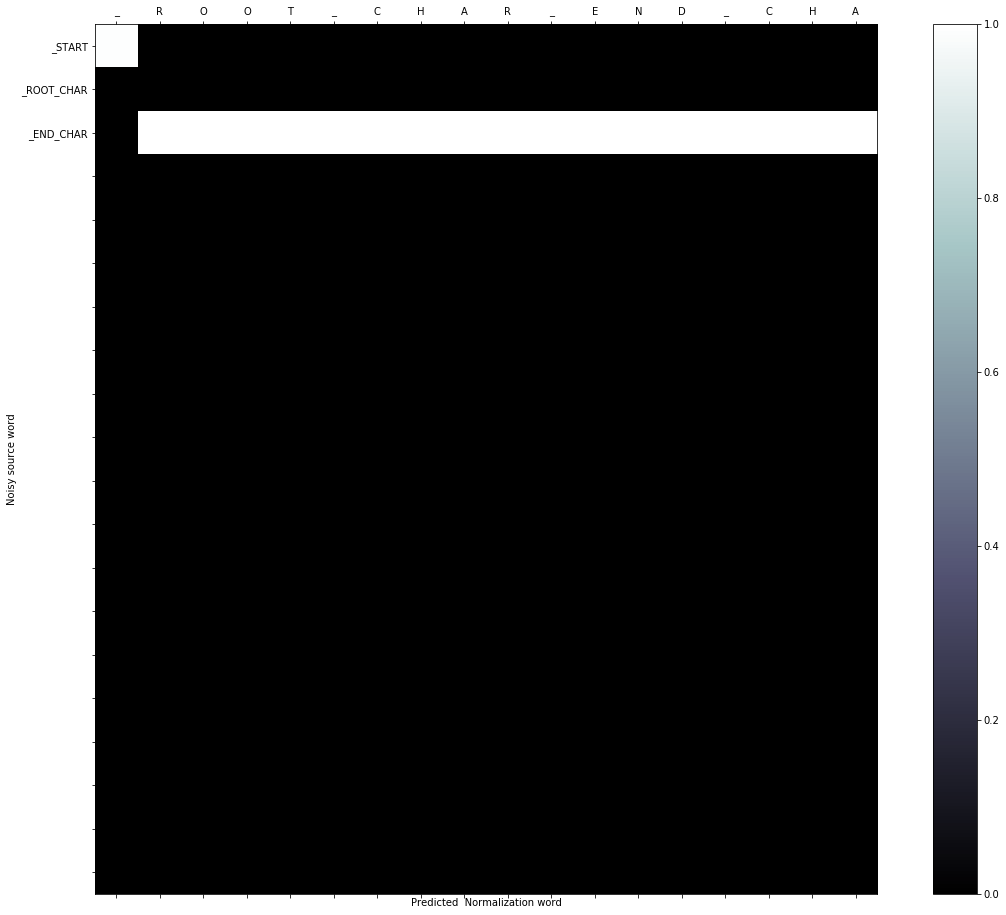

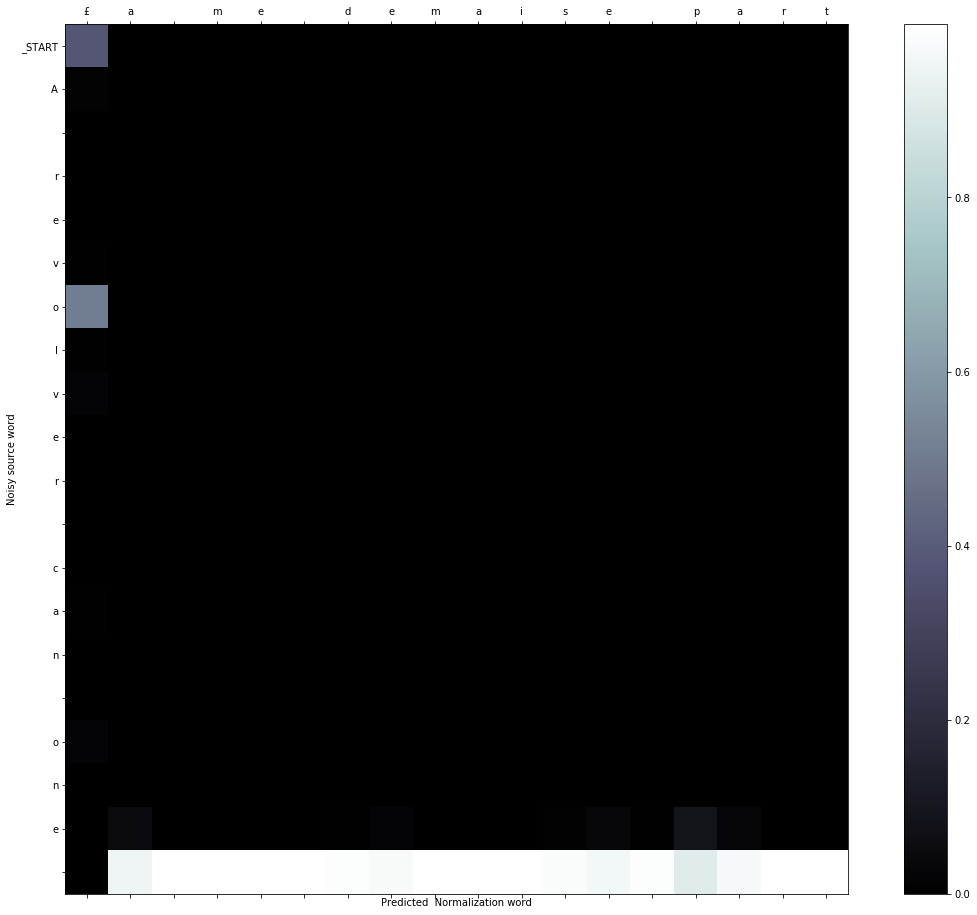

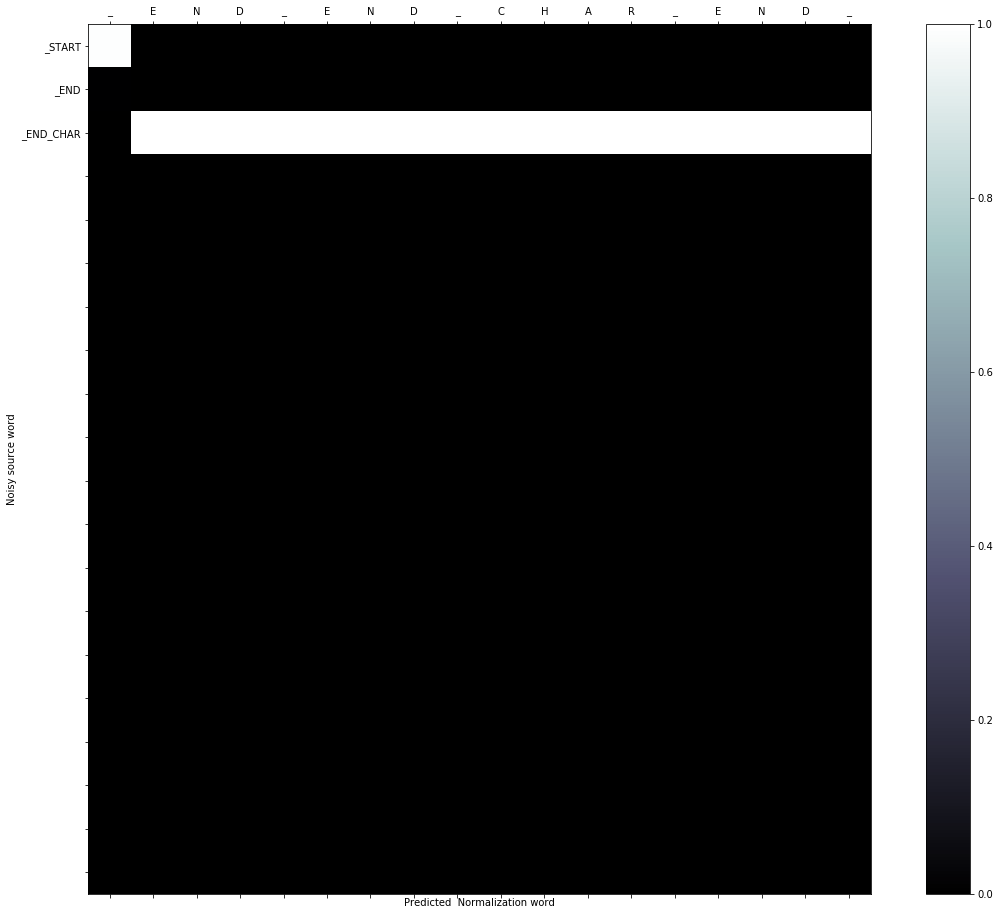

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', '£a me demaise part', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTA revolver can one', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    A review on Studio Series Blackout!
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['A review on Studio Series Blackout!']


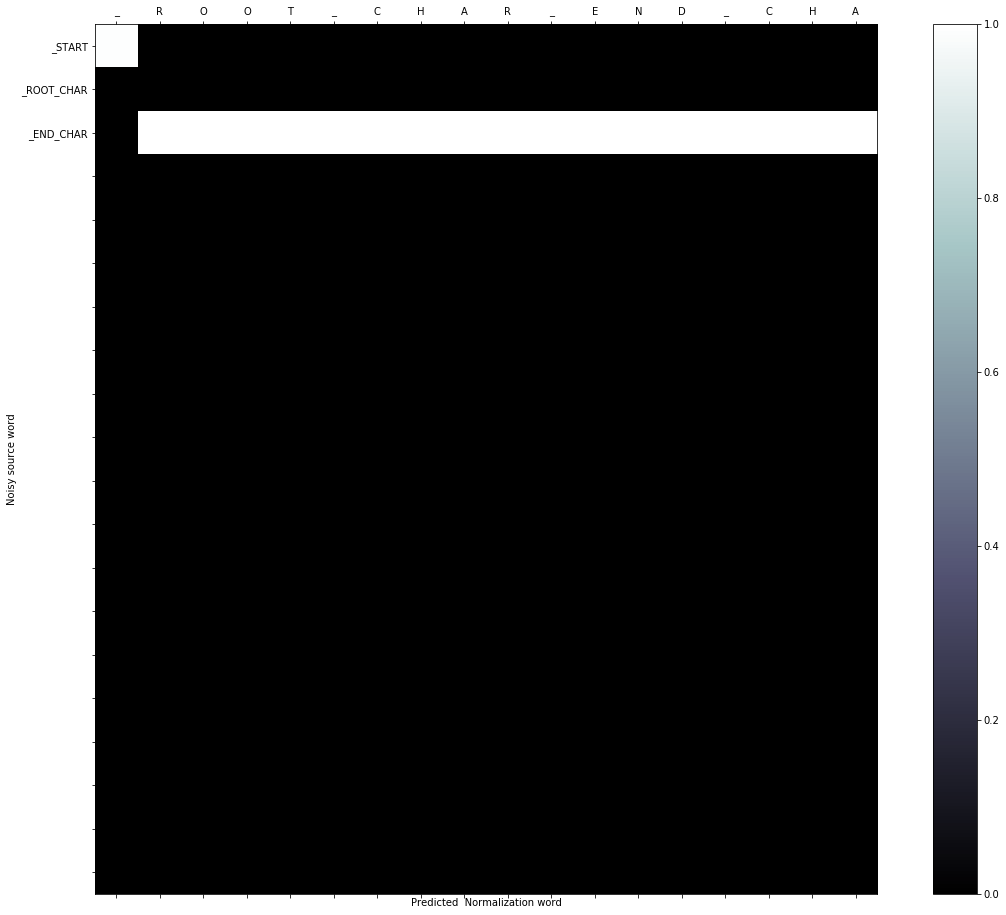

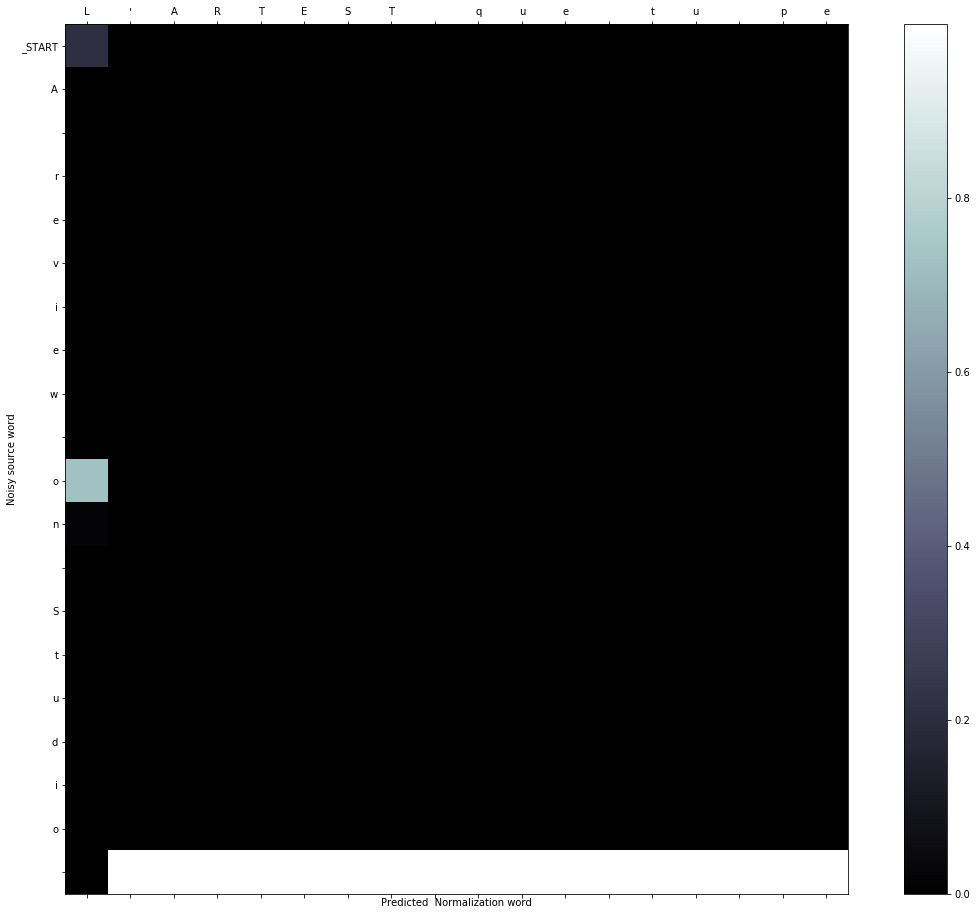

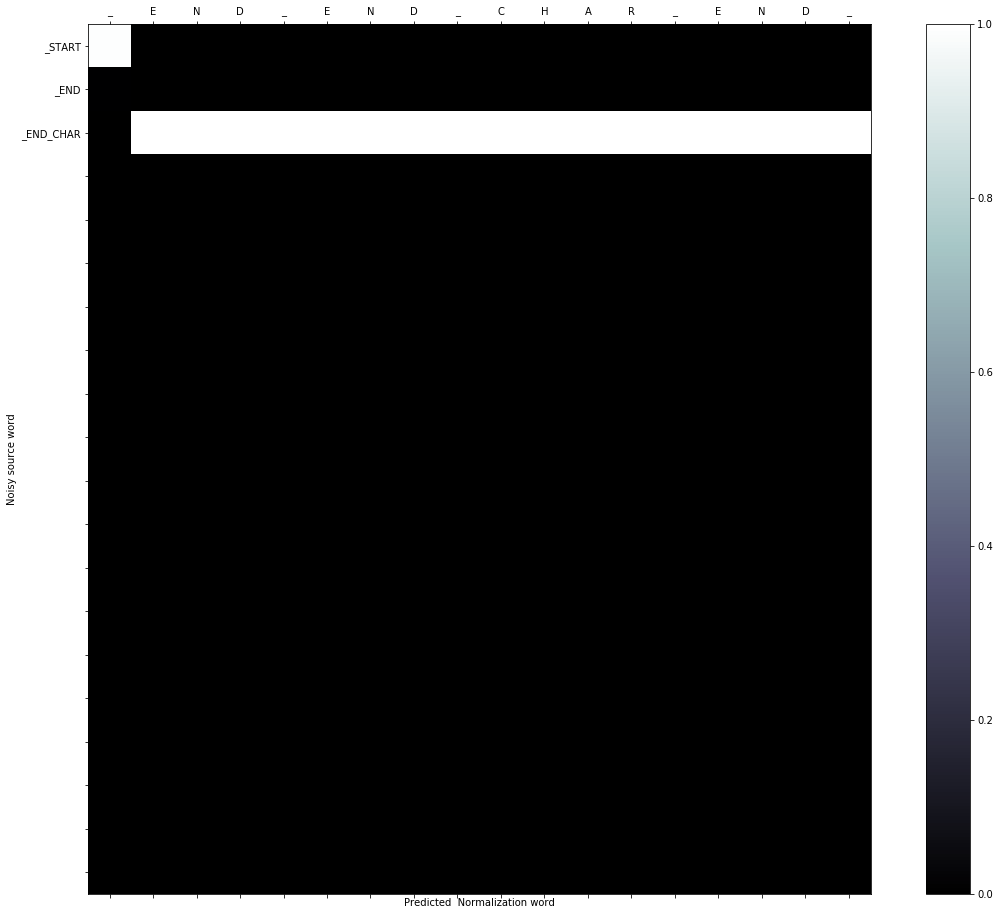

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', "L'ARTEST que tu pe", '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTA review on Studio', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are we vaping with hemp rope now?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are we vaping with hemp rope now?']


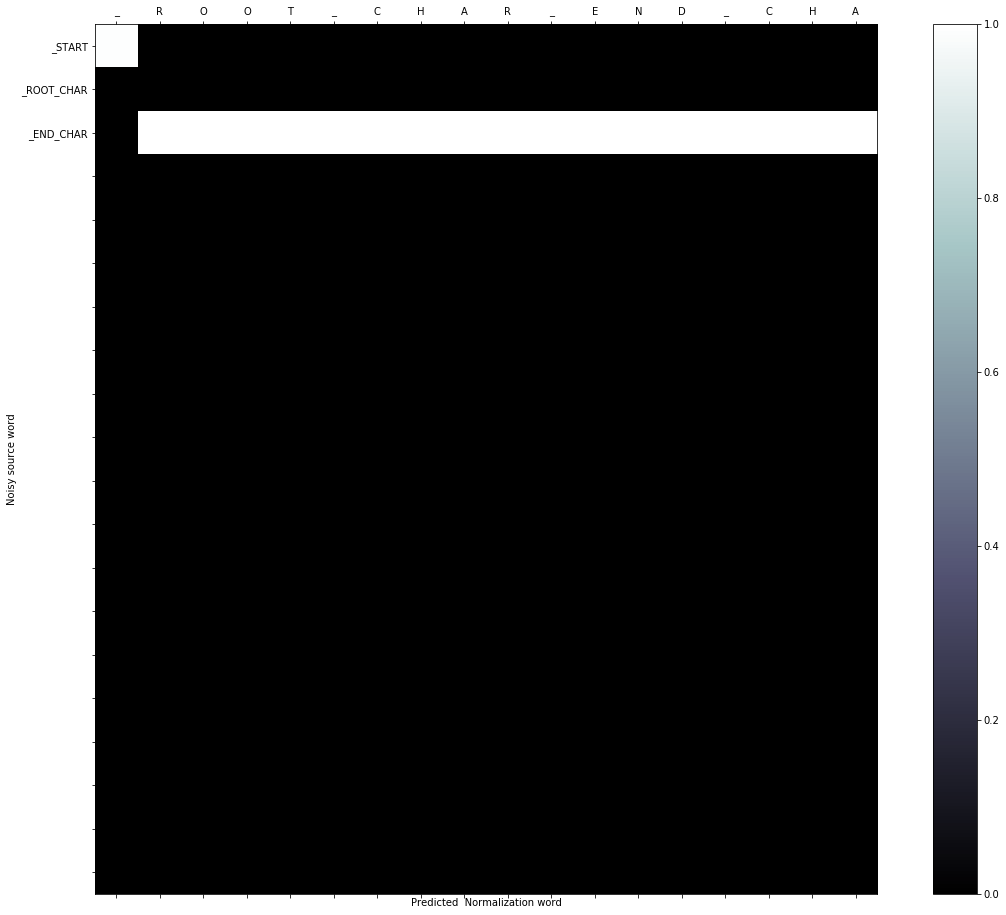

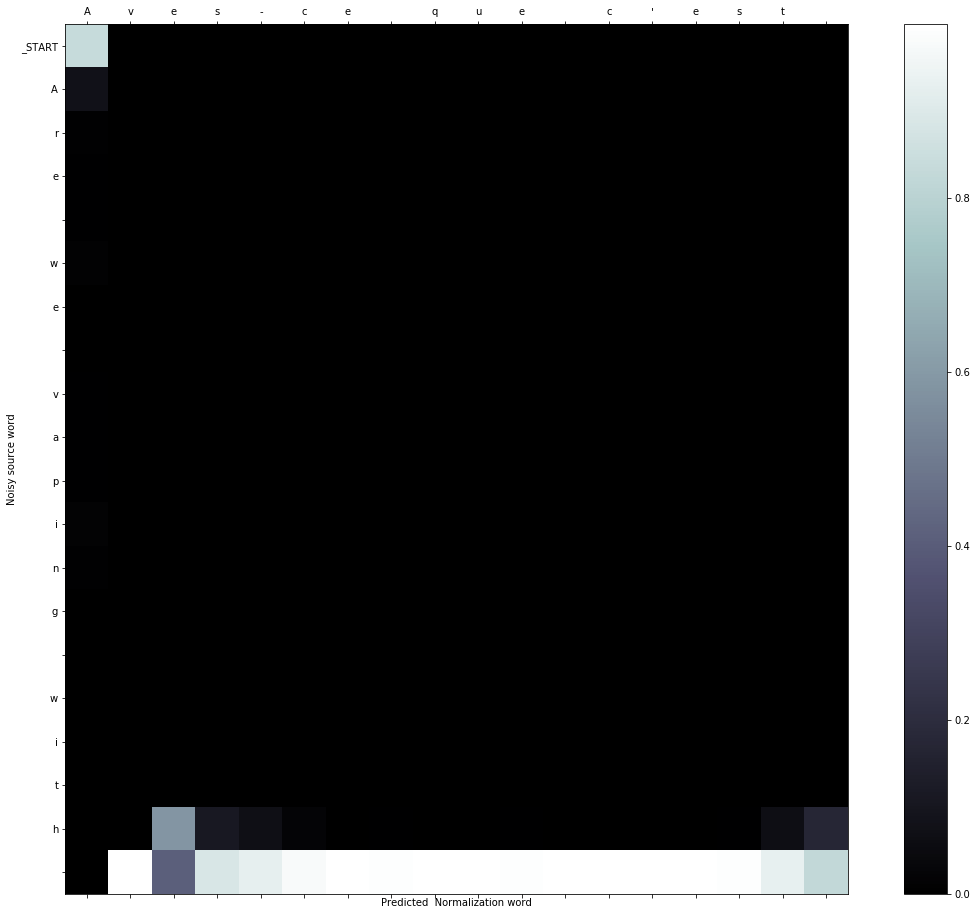

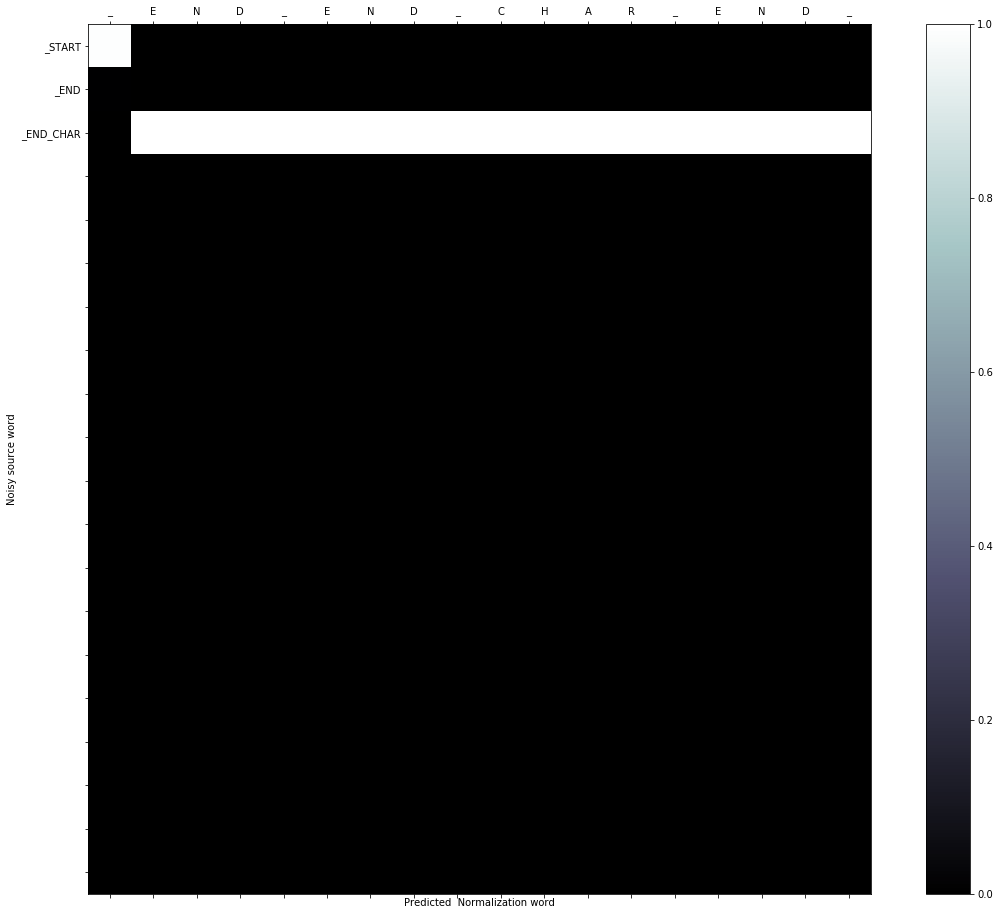

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', "Aves-ce que c'est ", '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre we vaping with', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you a car enthusiast?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you a car enthusiast?']


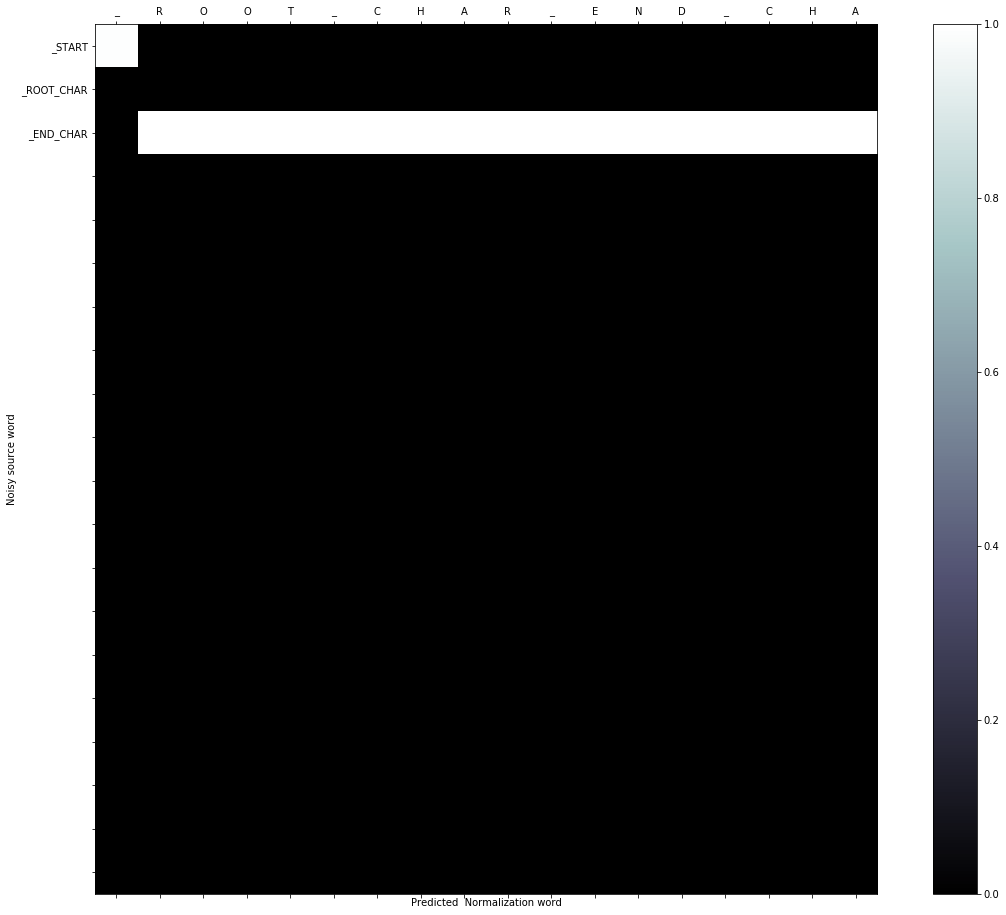

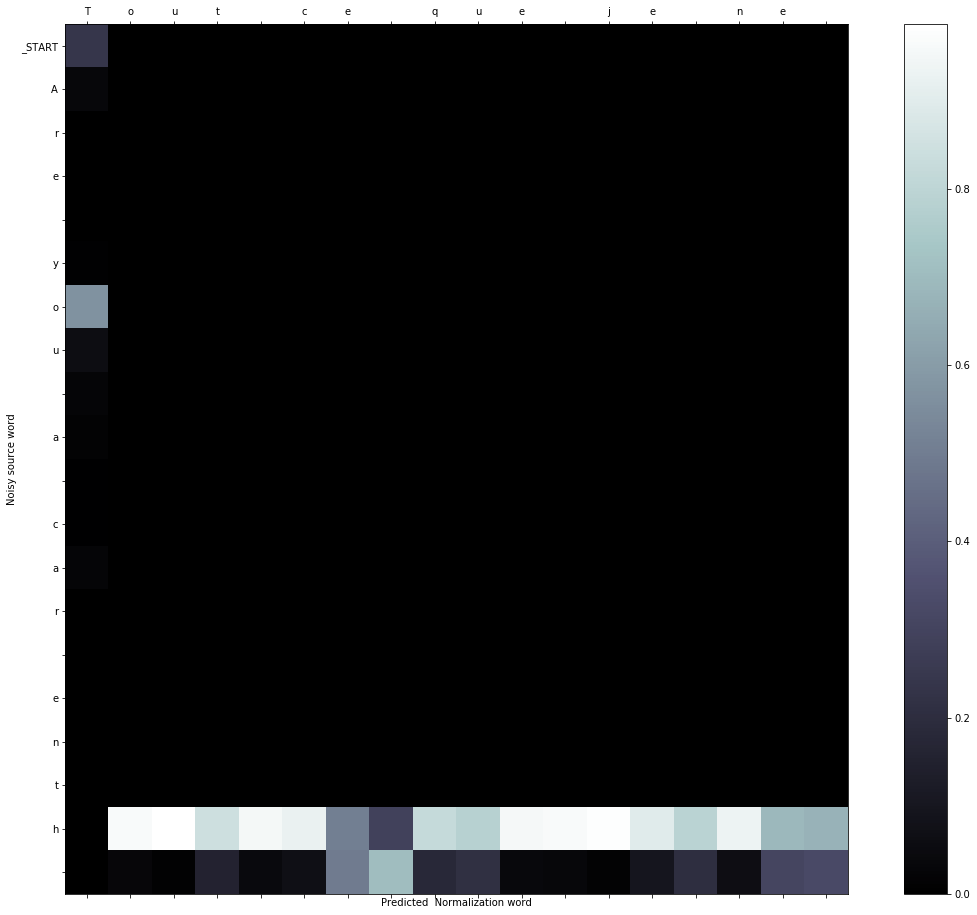

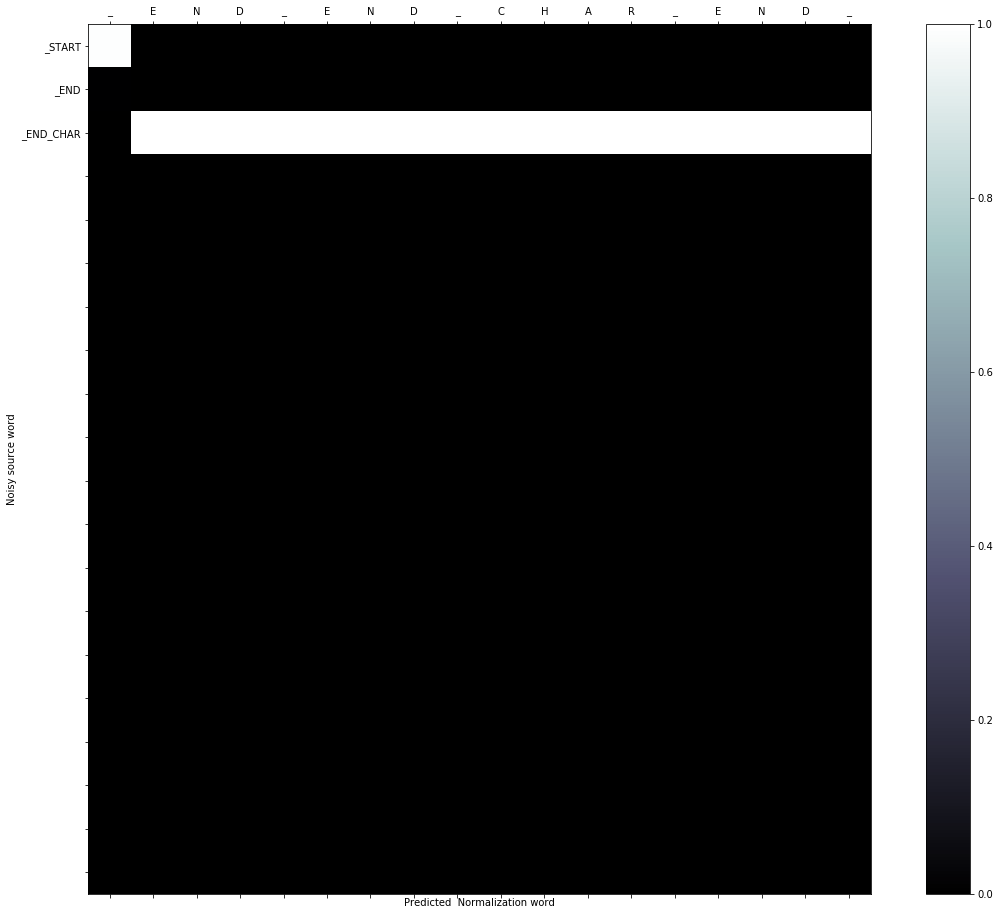

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Tout ce que je ne ', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you a car enth', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you a vegetarian?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you a vegetarian?']


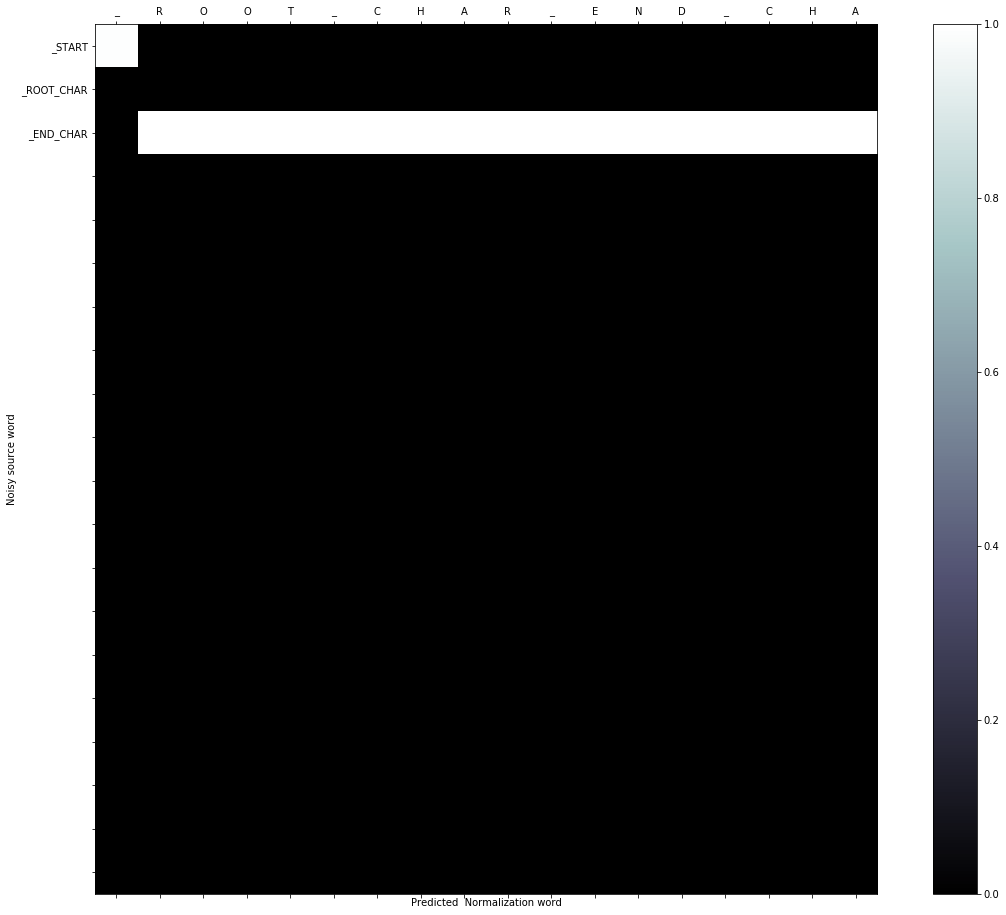

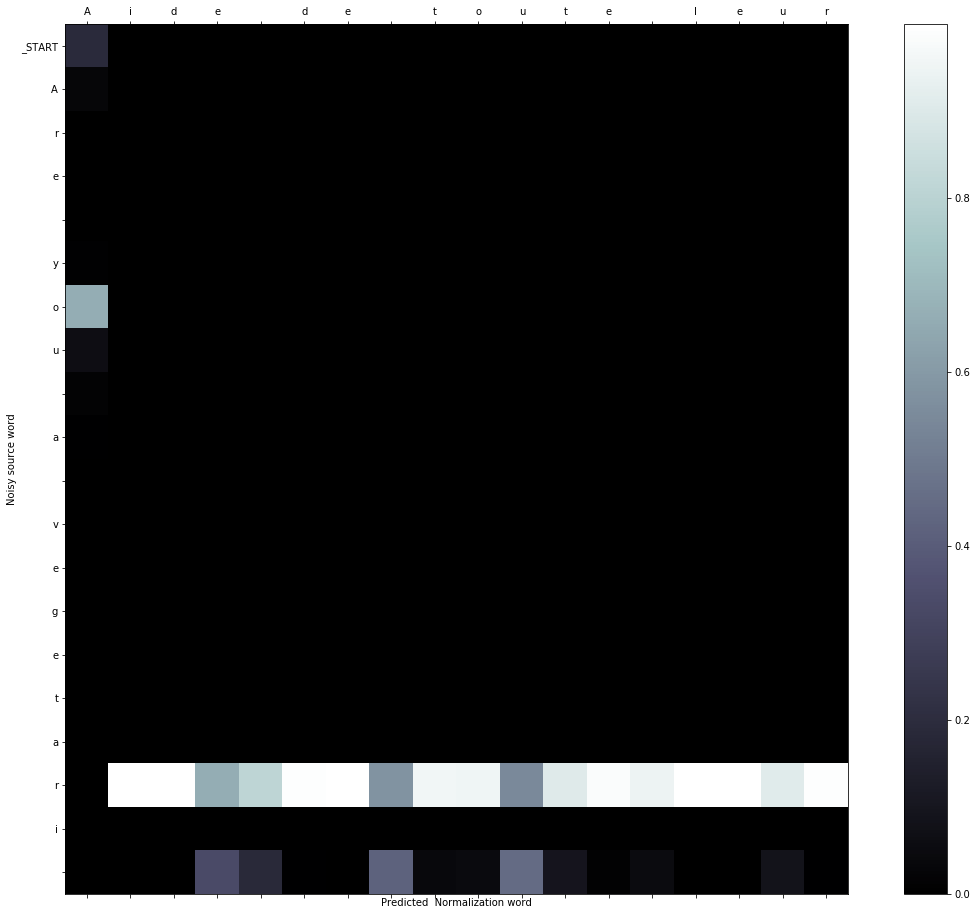

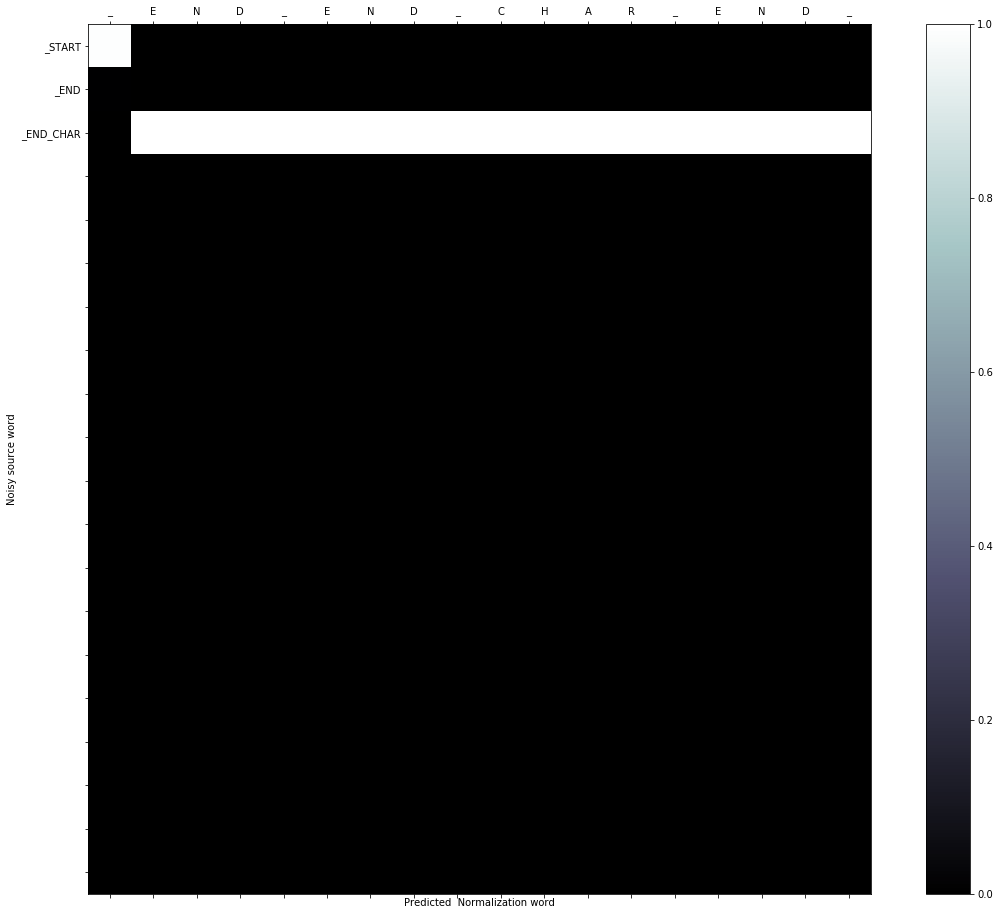

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Aide de toute leur', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you a vegetari', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you Canadian?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you Canadian?']


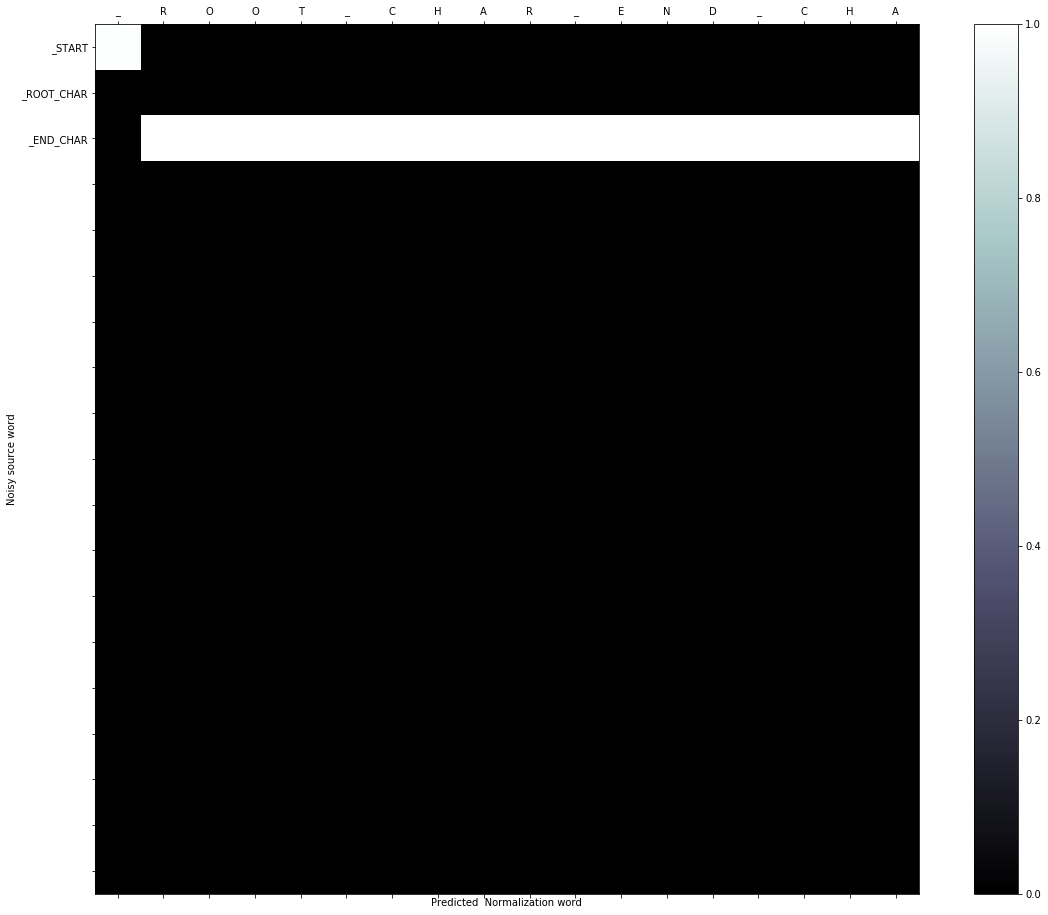

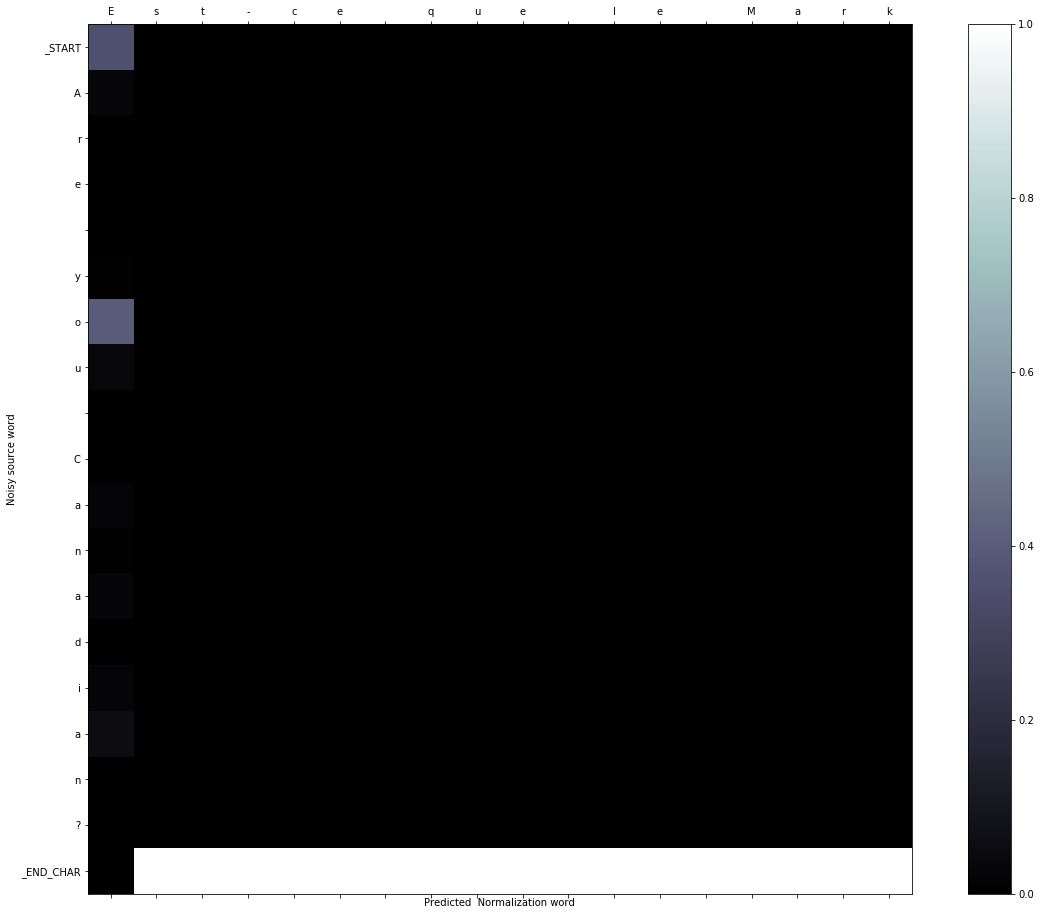

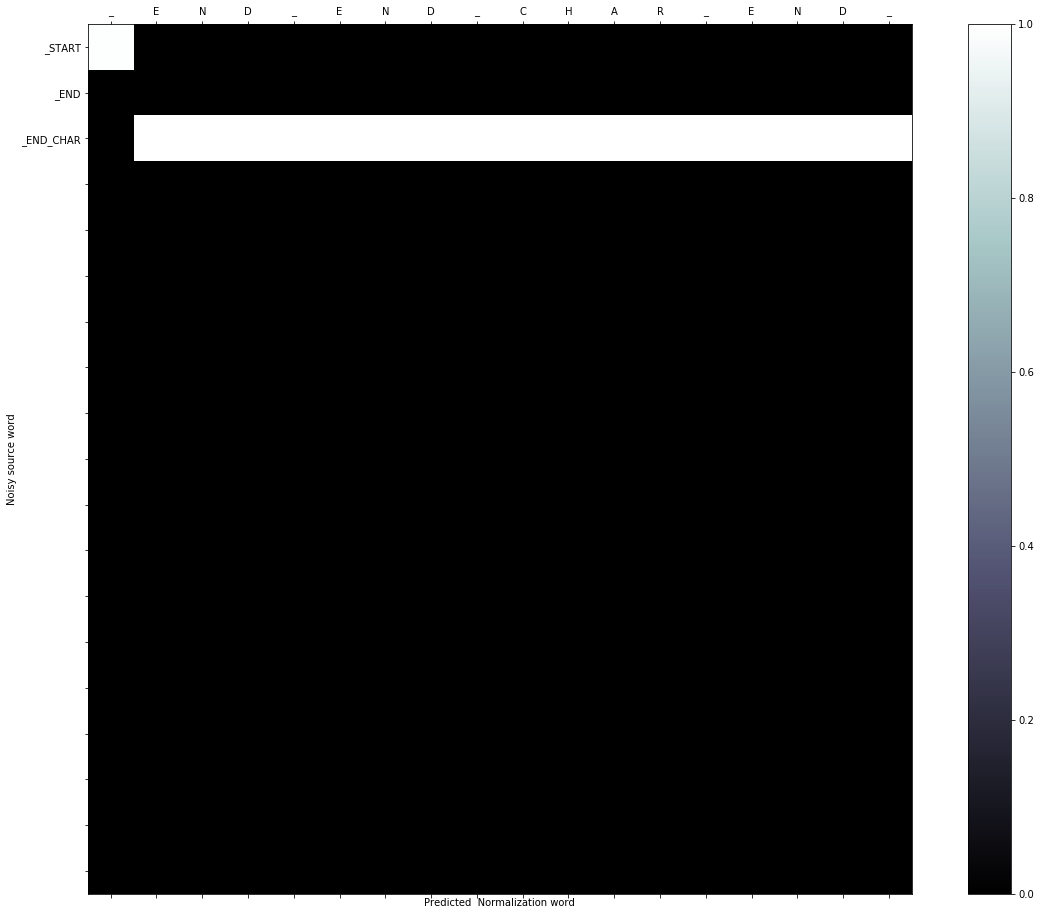

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Est-ce que le Mark', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you Canadian?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you ok ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you ok ?']


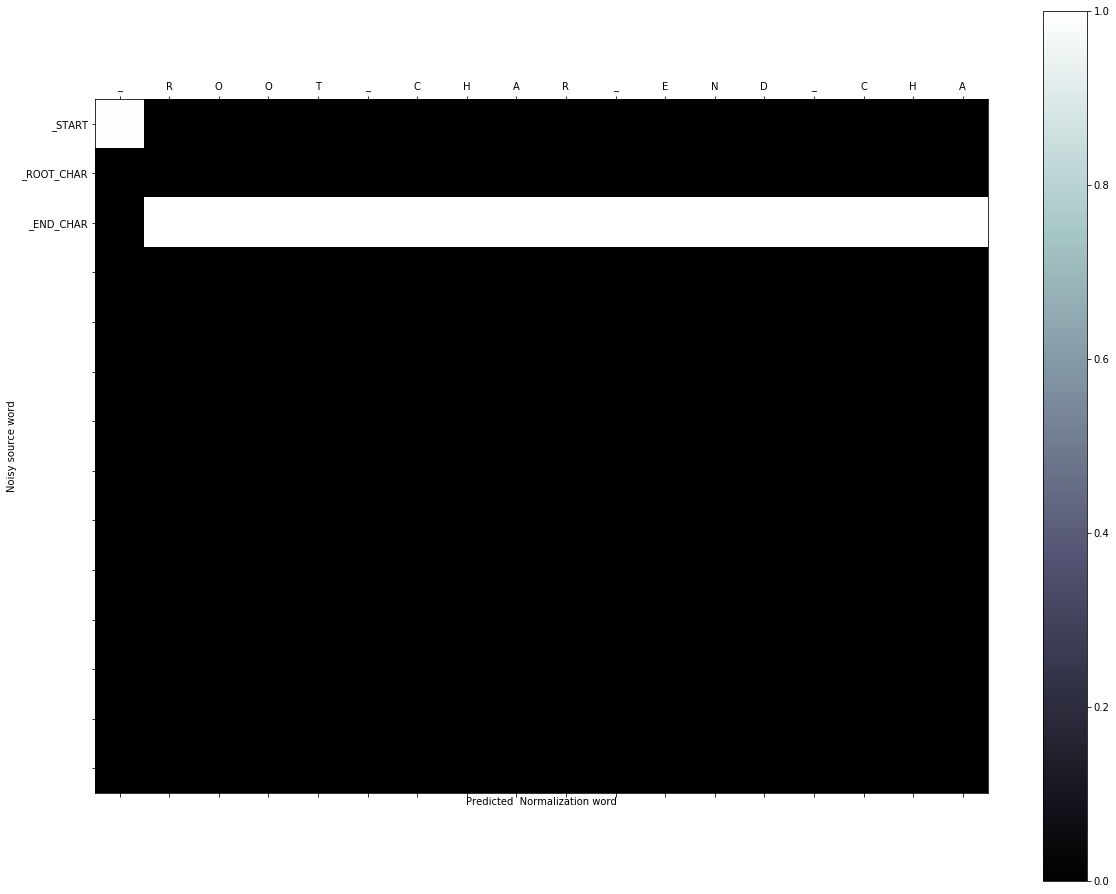

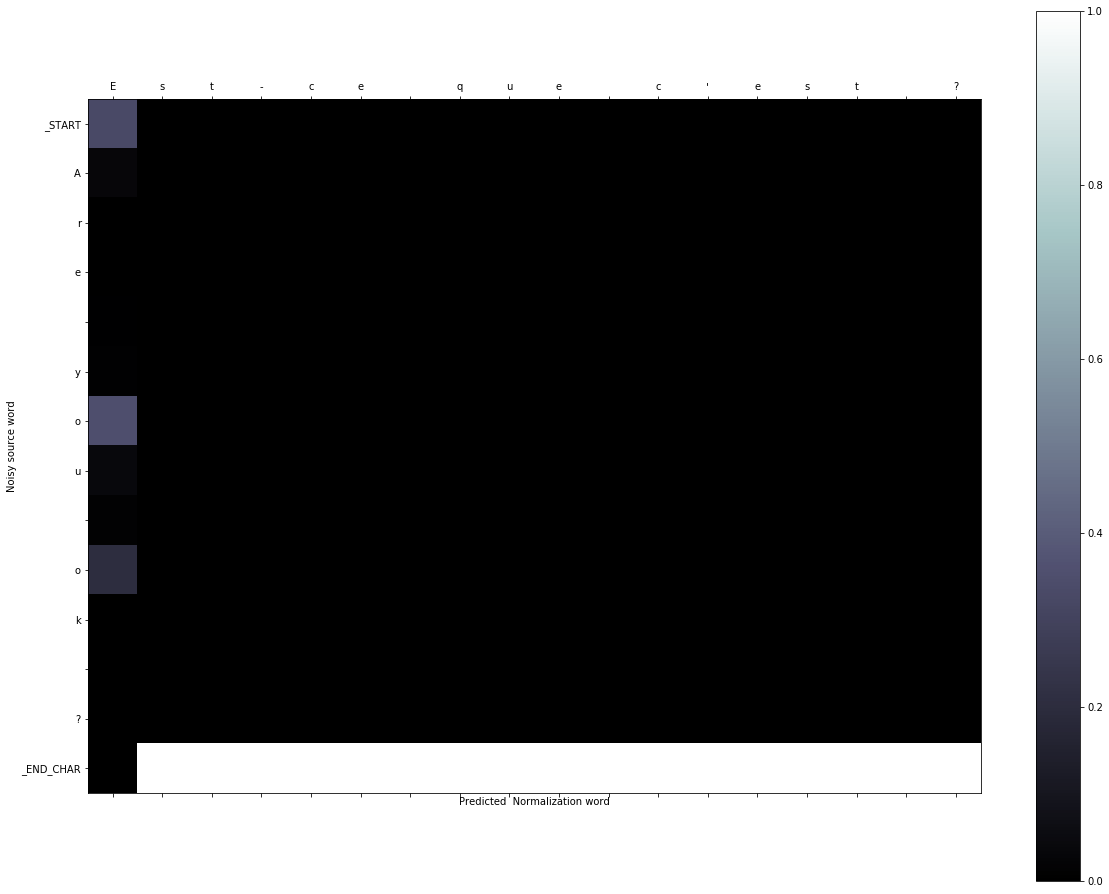

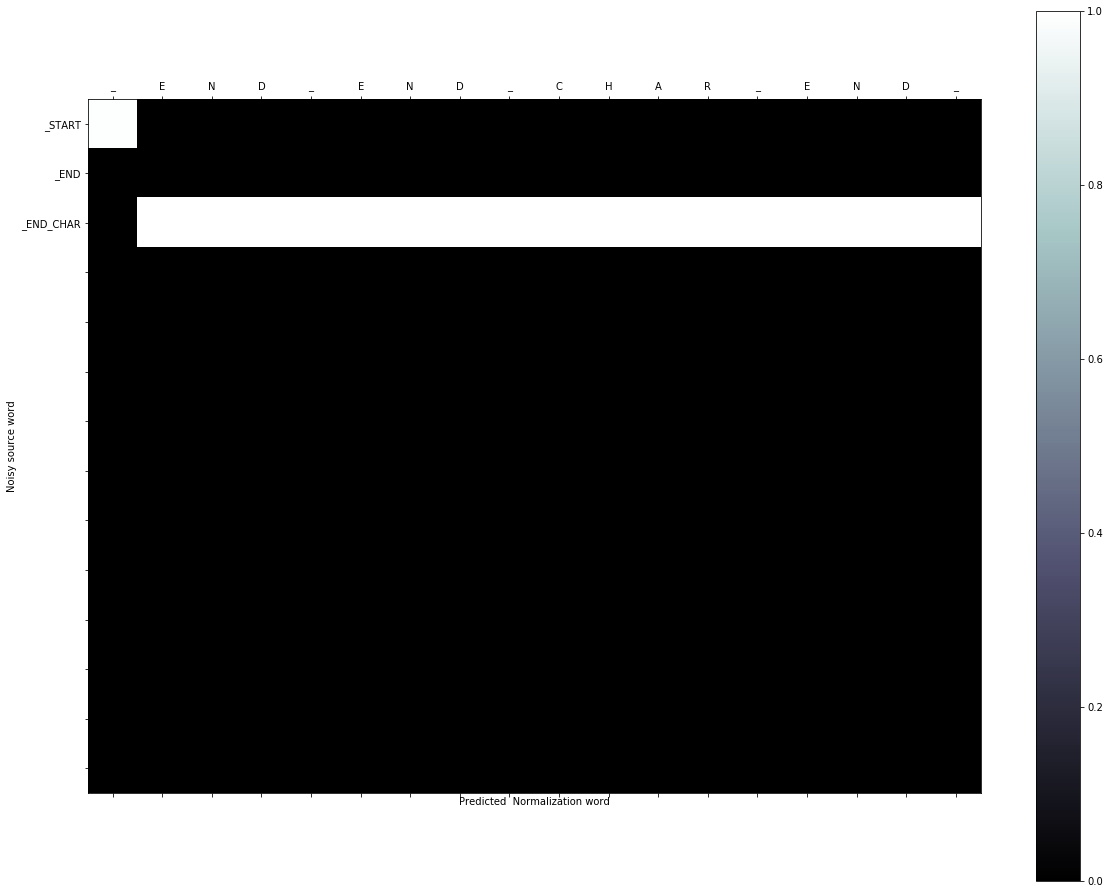

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', "Est-ce que c'est ?", '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you ok ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you fine ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you fine ?']


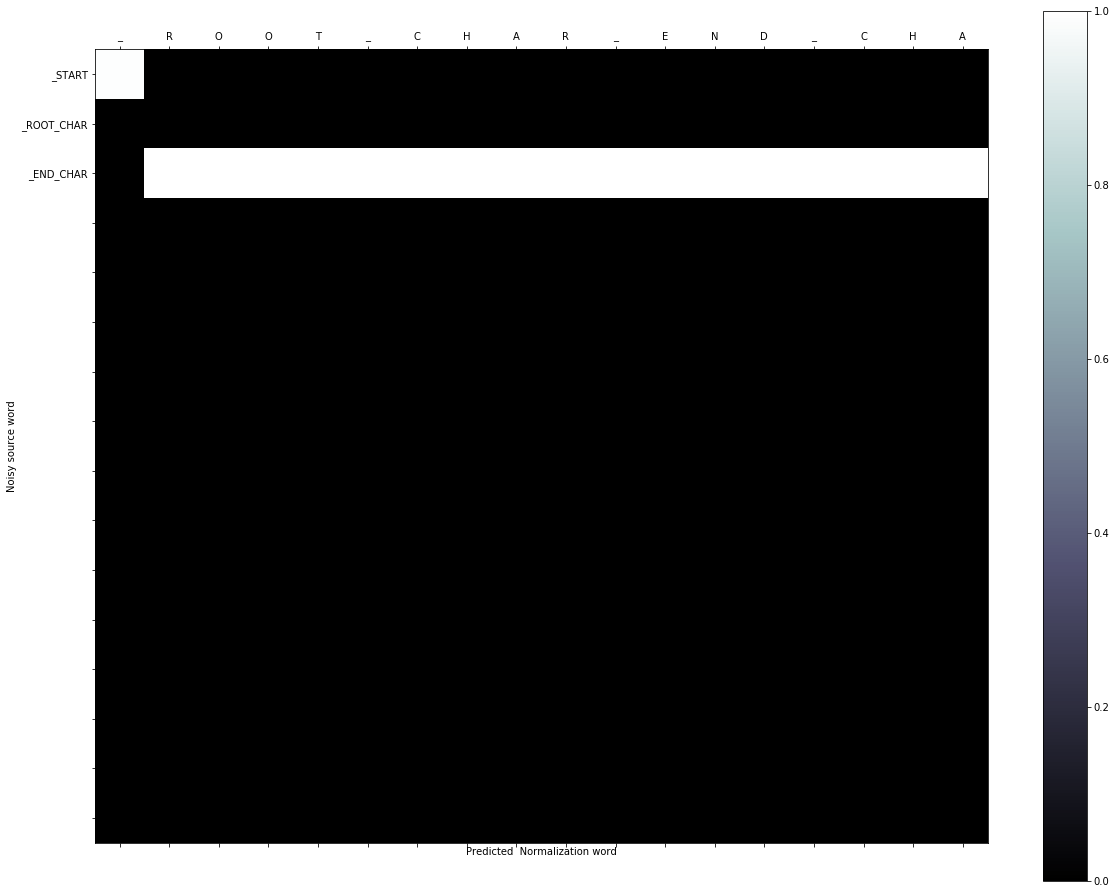

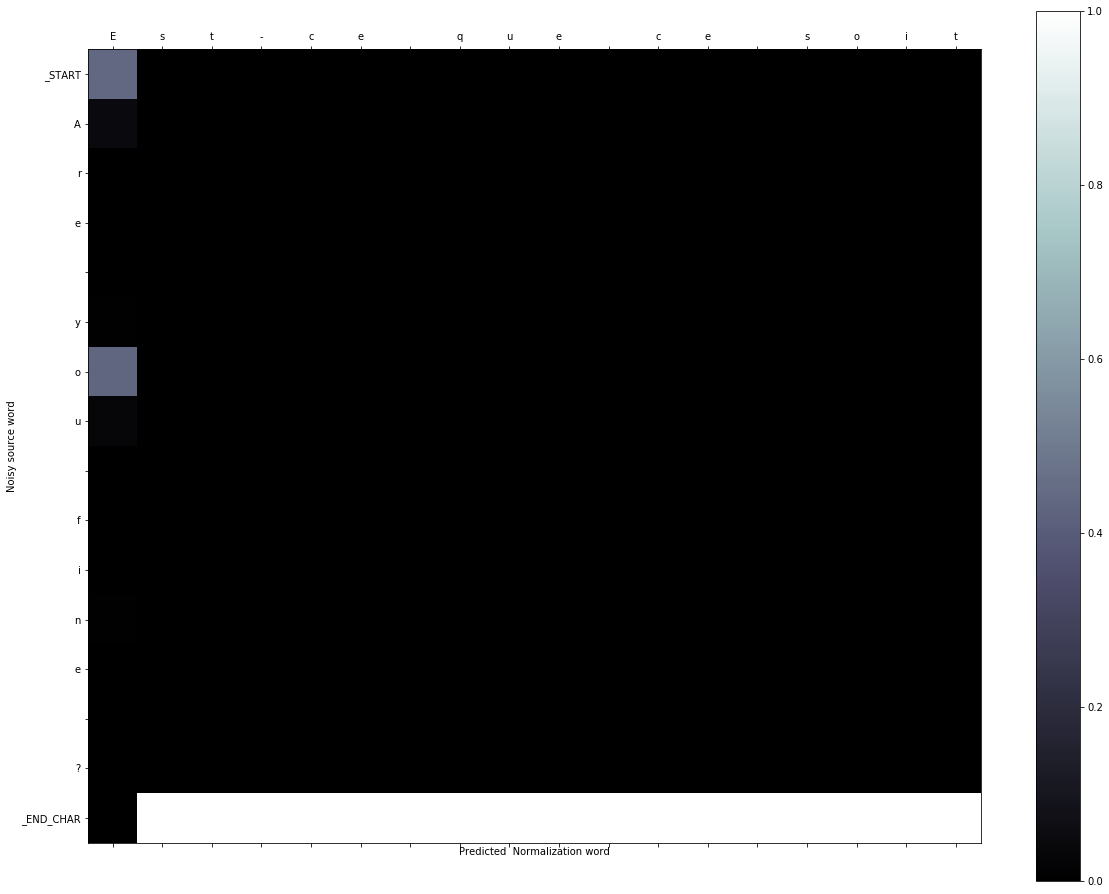

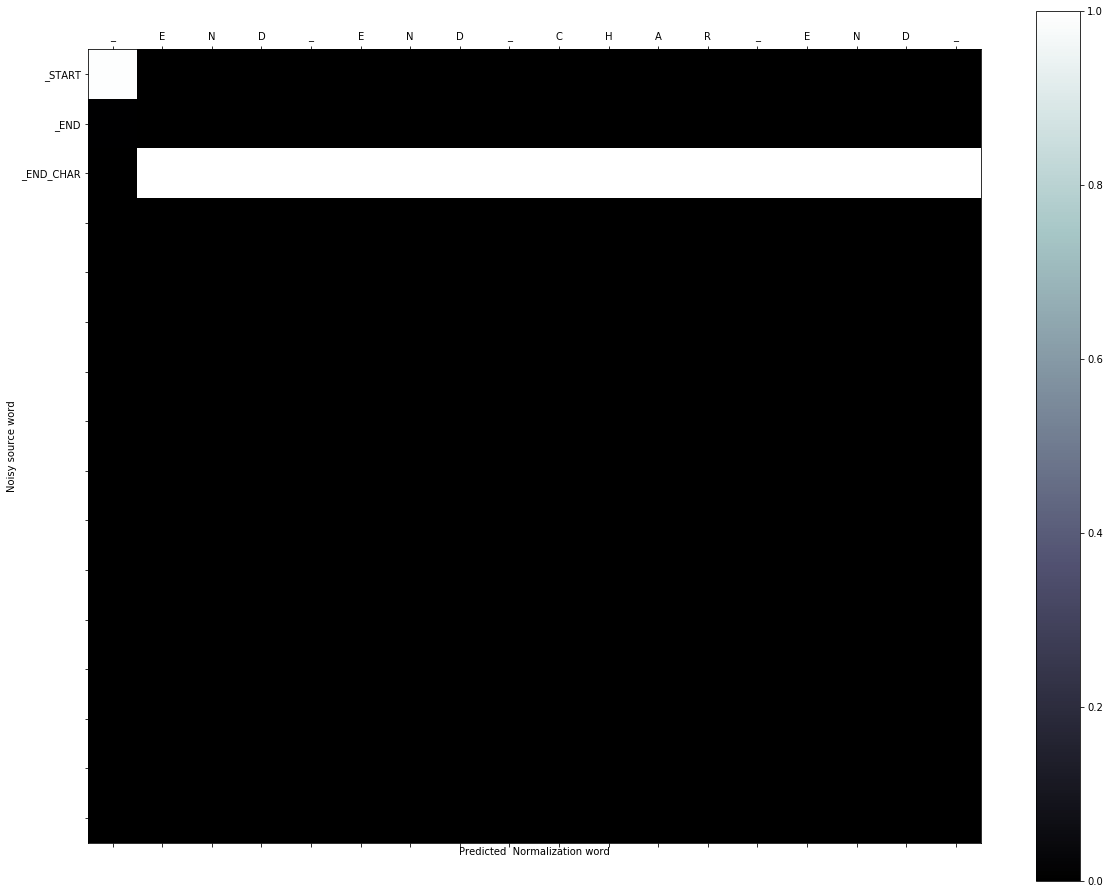

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Est-ce que ce soit', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you fine ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you close to 35406
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you close to 35406']


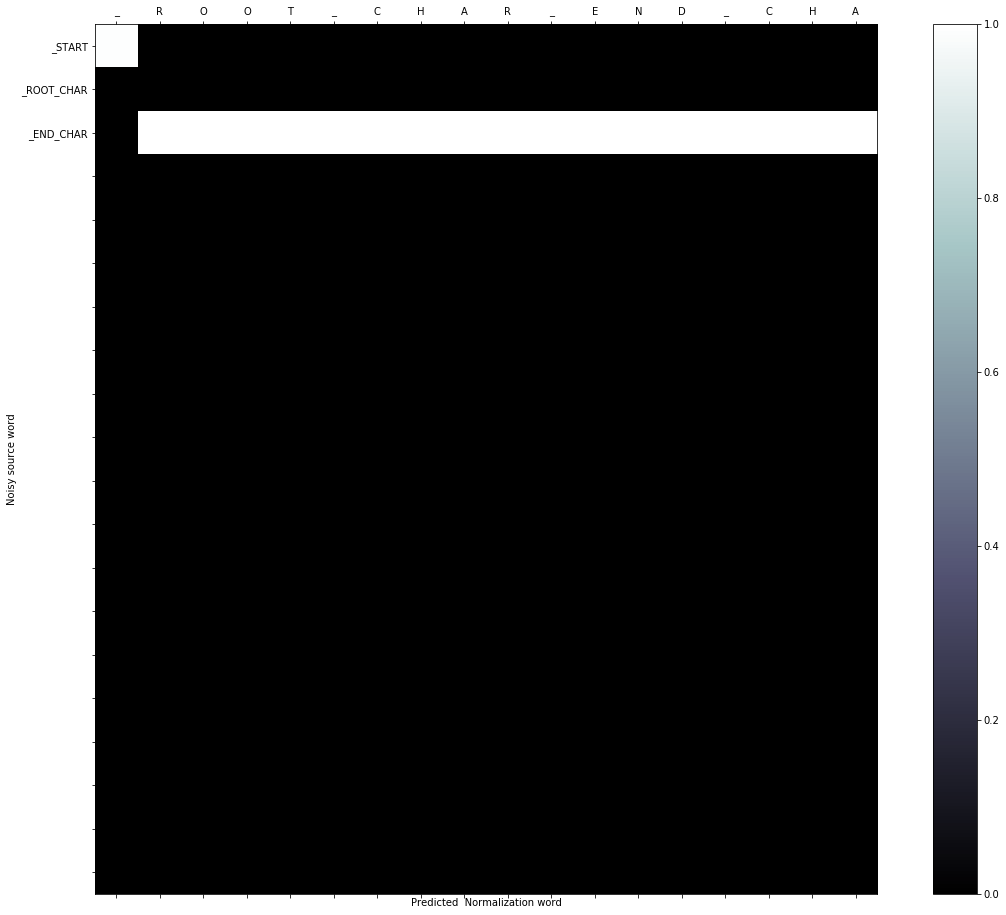

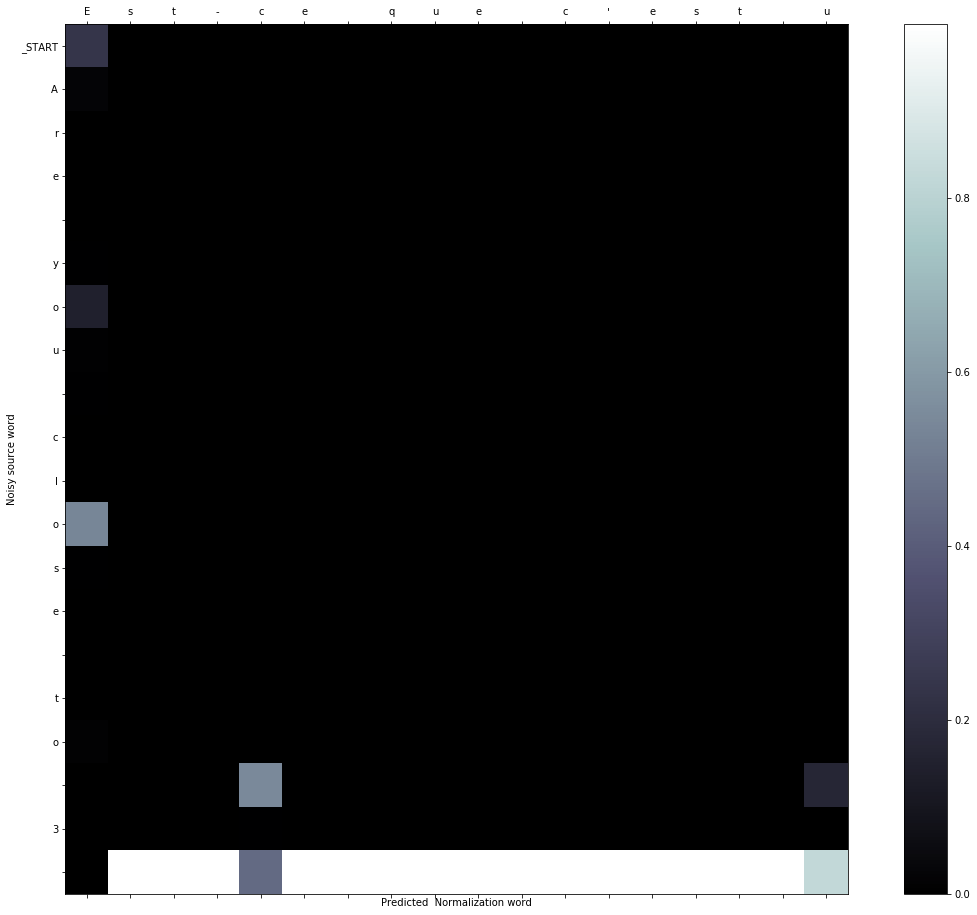

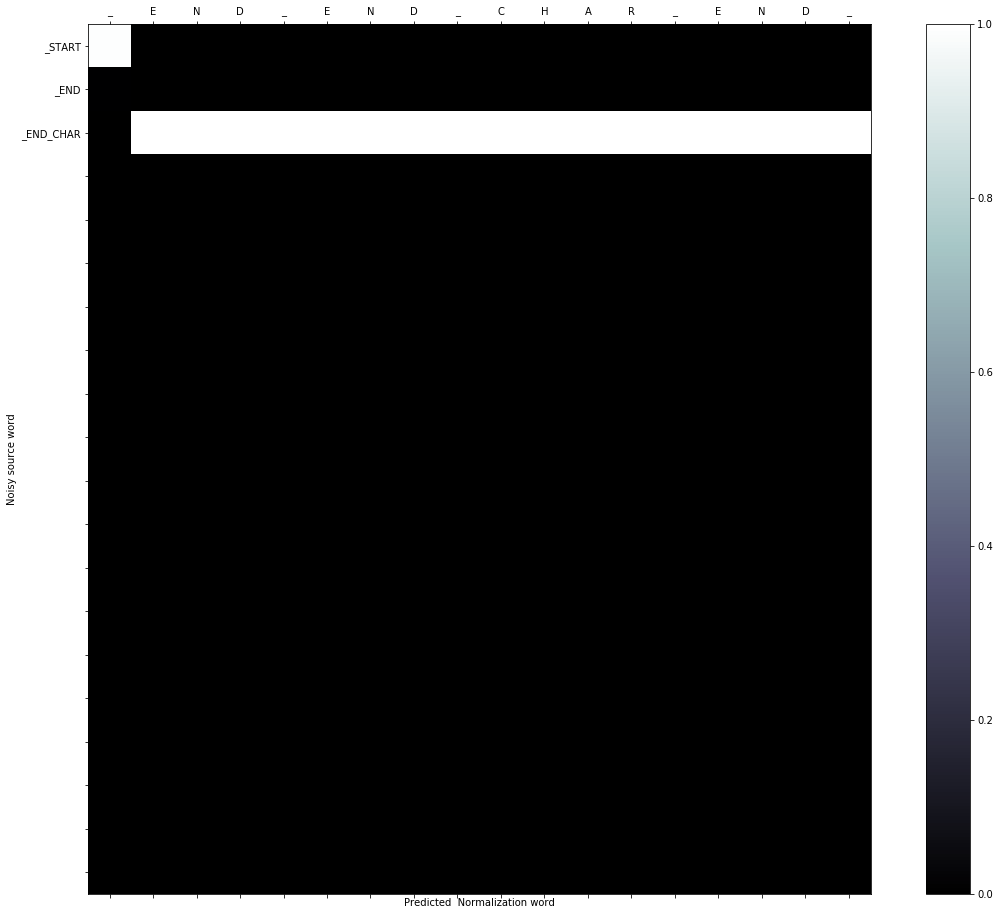

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', "Est-ce que c'est u", '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you close to 3', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you guys liking it ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you guys liking it ?']


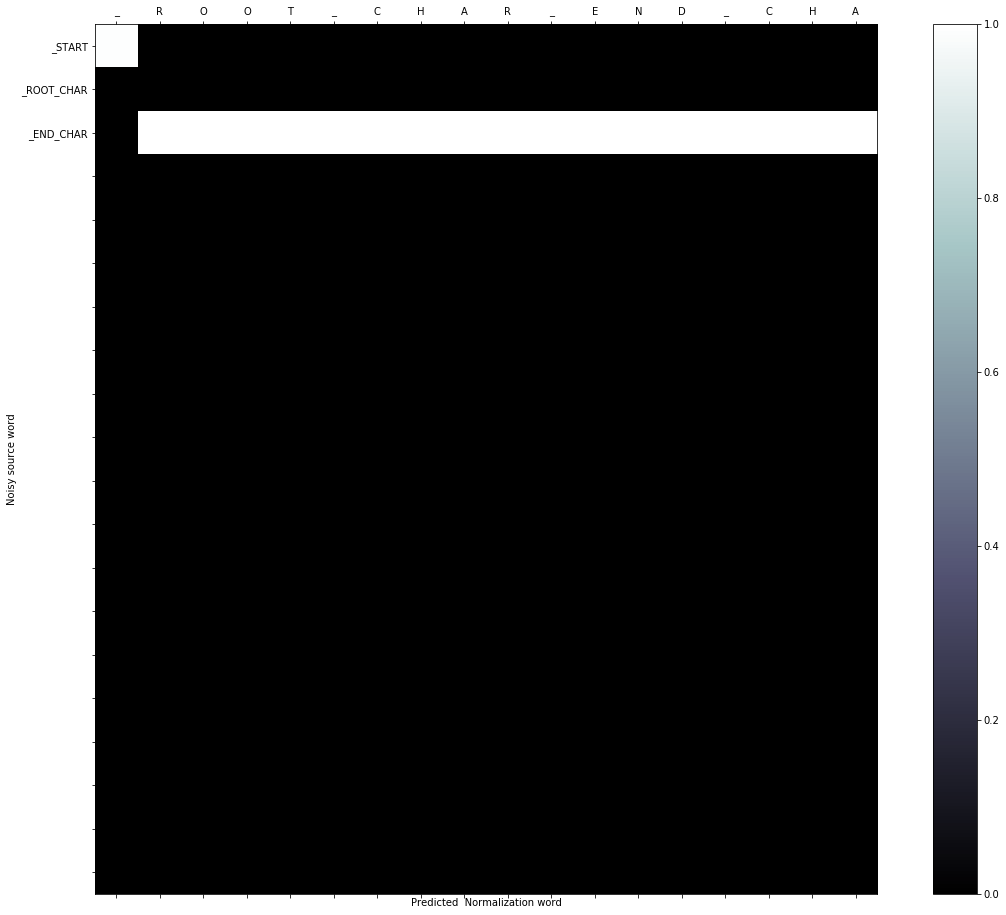

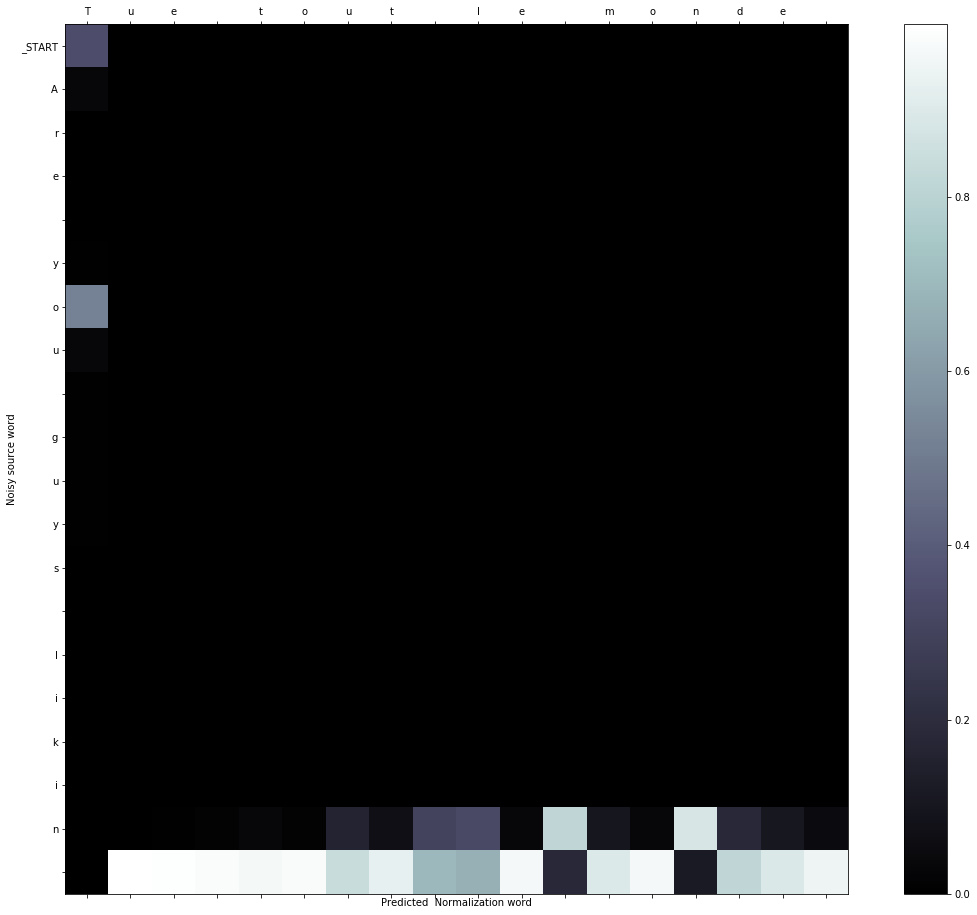

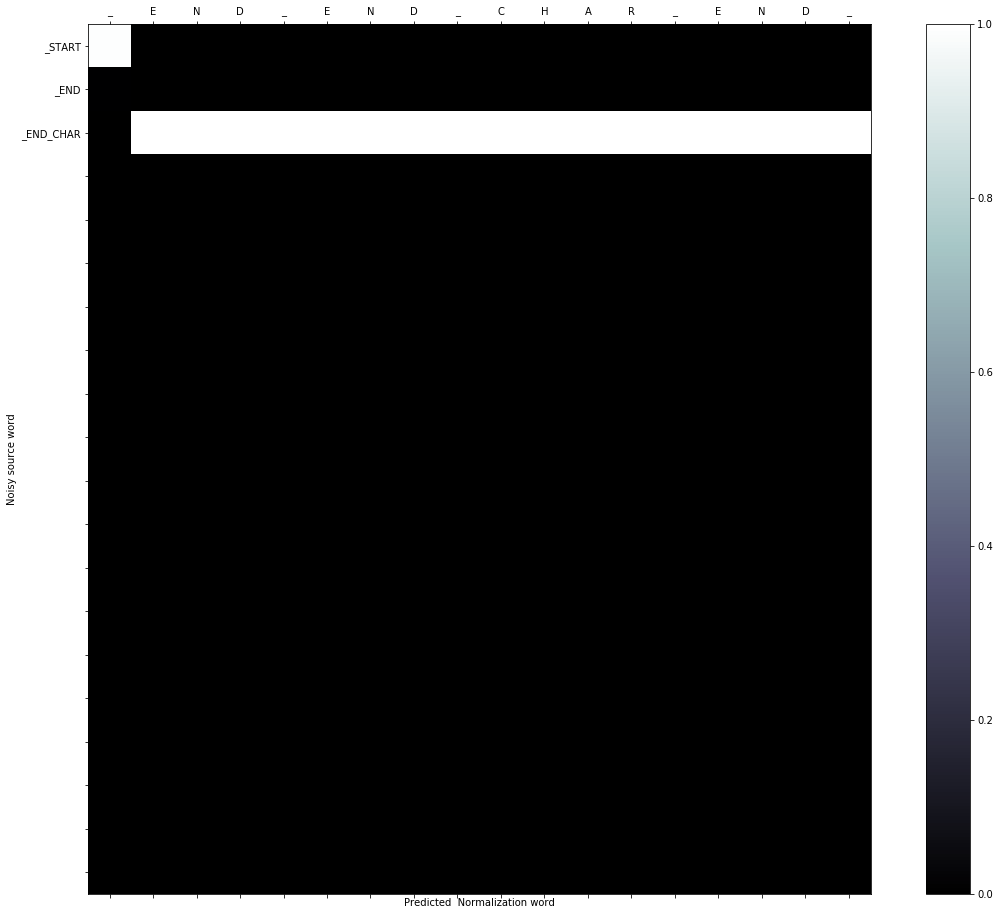

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Tue tout le monde ', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you guys likin', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you guys ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    sotp
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you guys ?', 'sotp']


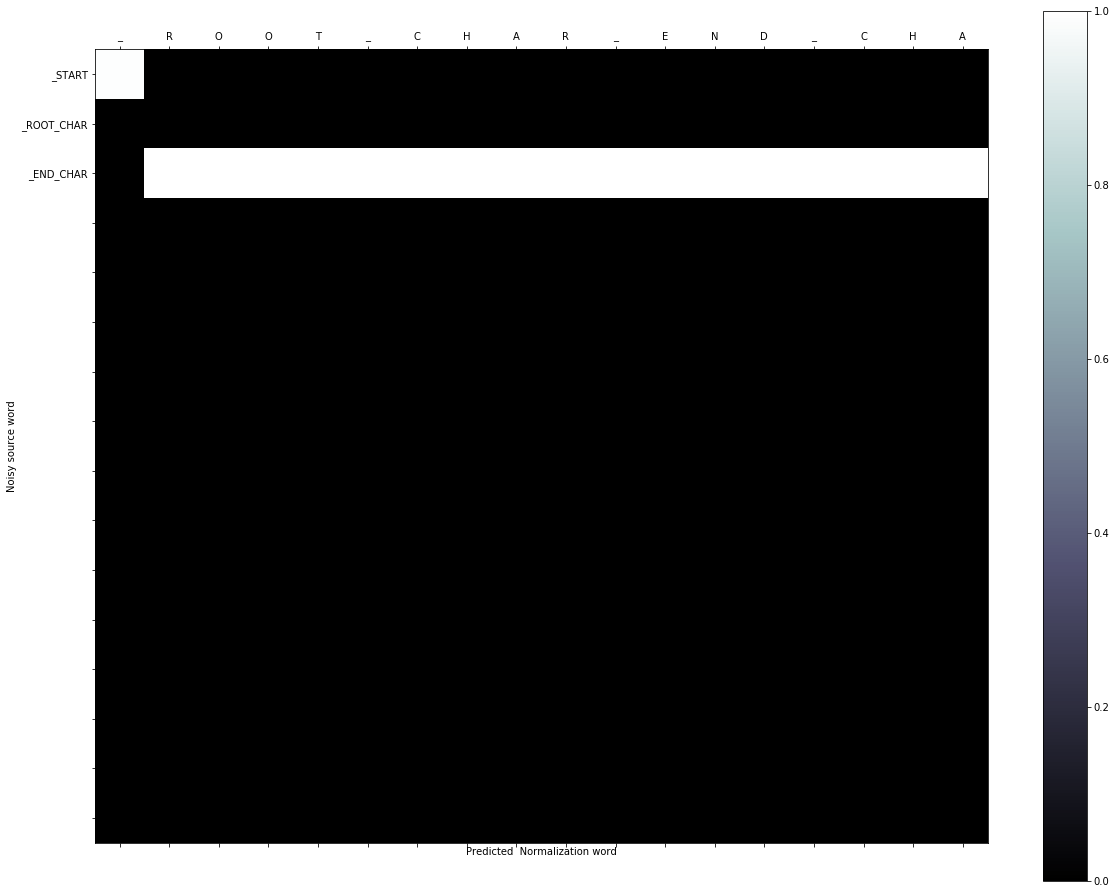

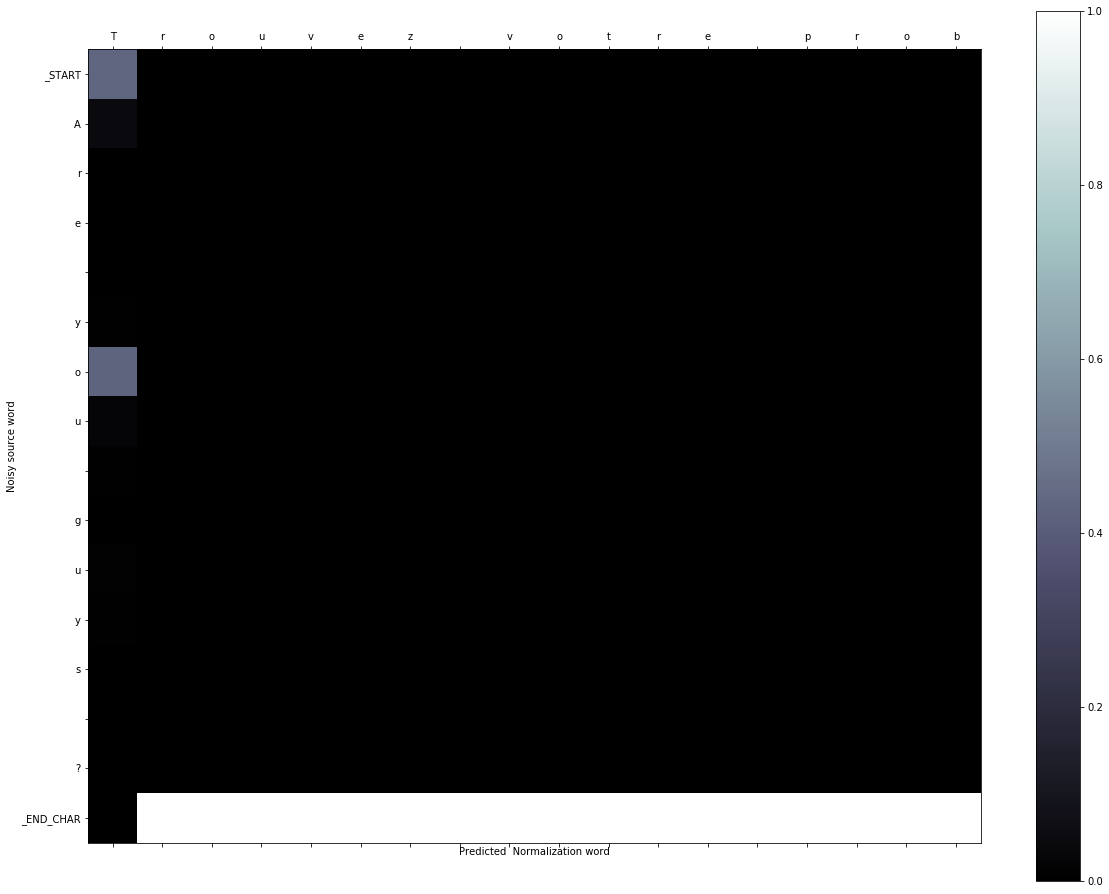

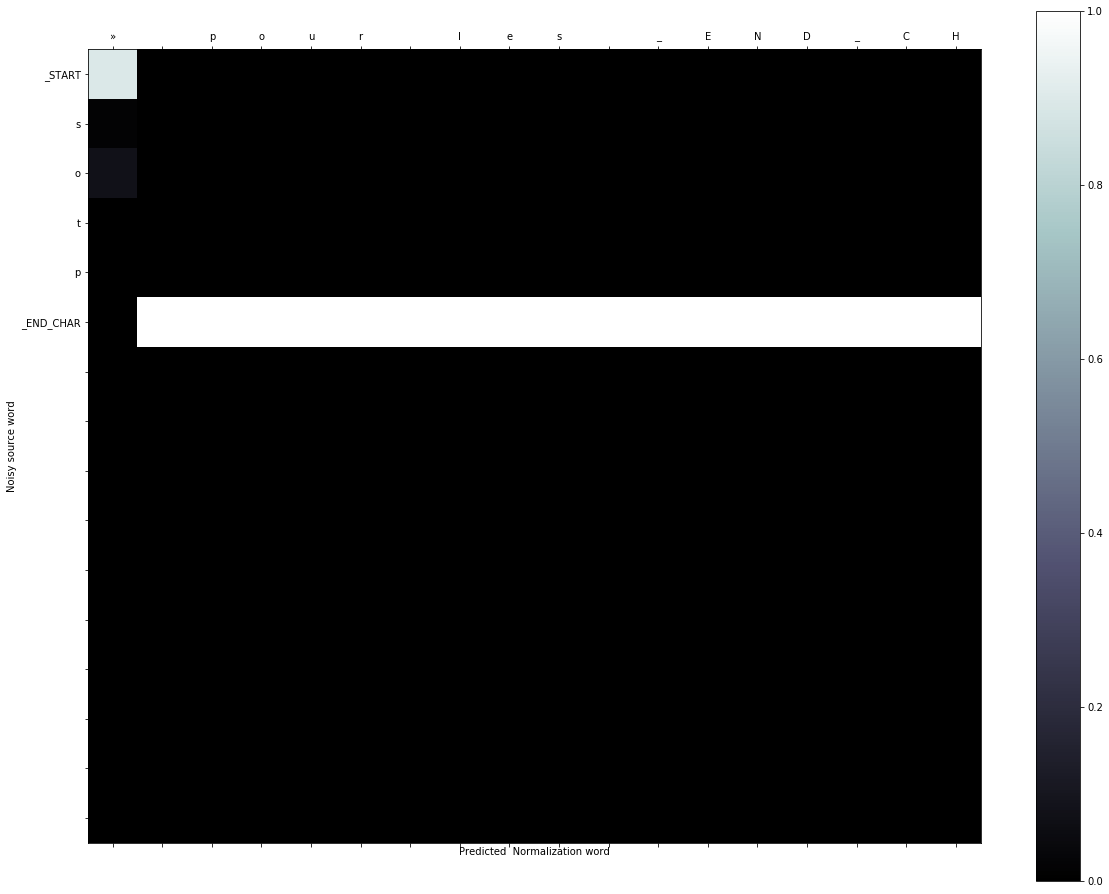

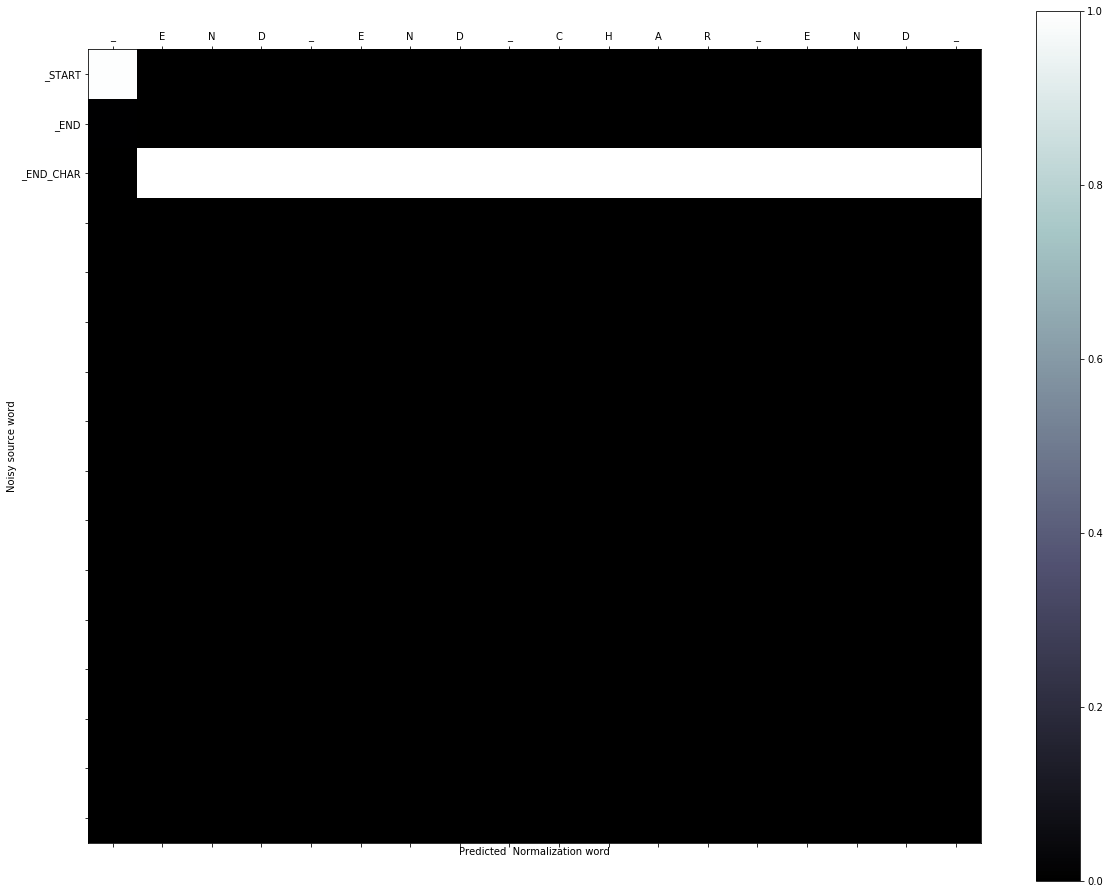

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Trouvez votre prob', '» pour les _END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you guys ?_END_CHAR', '_STARTsotp_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you guys ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you guys ?']


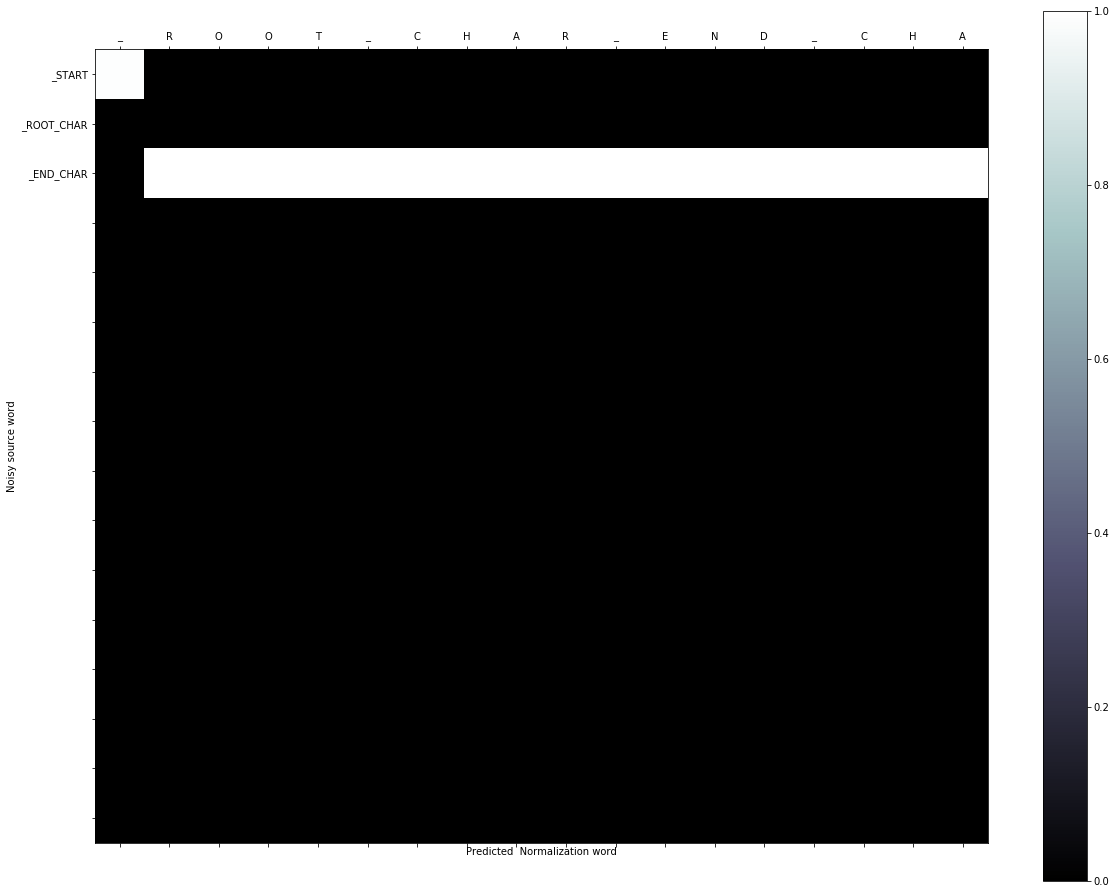

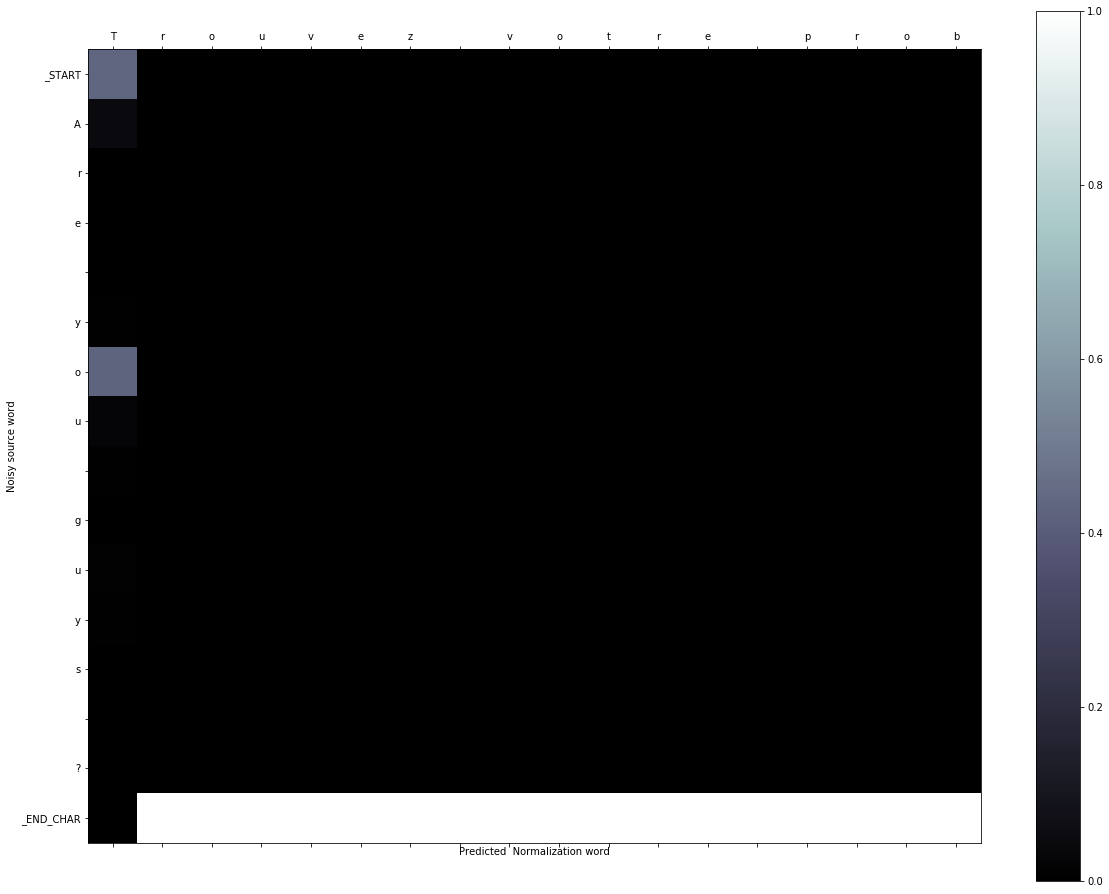

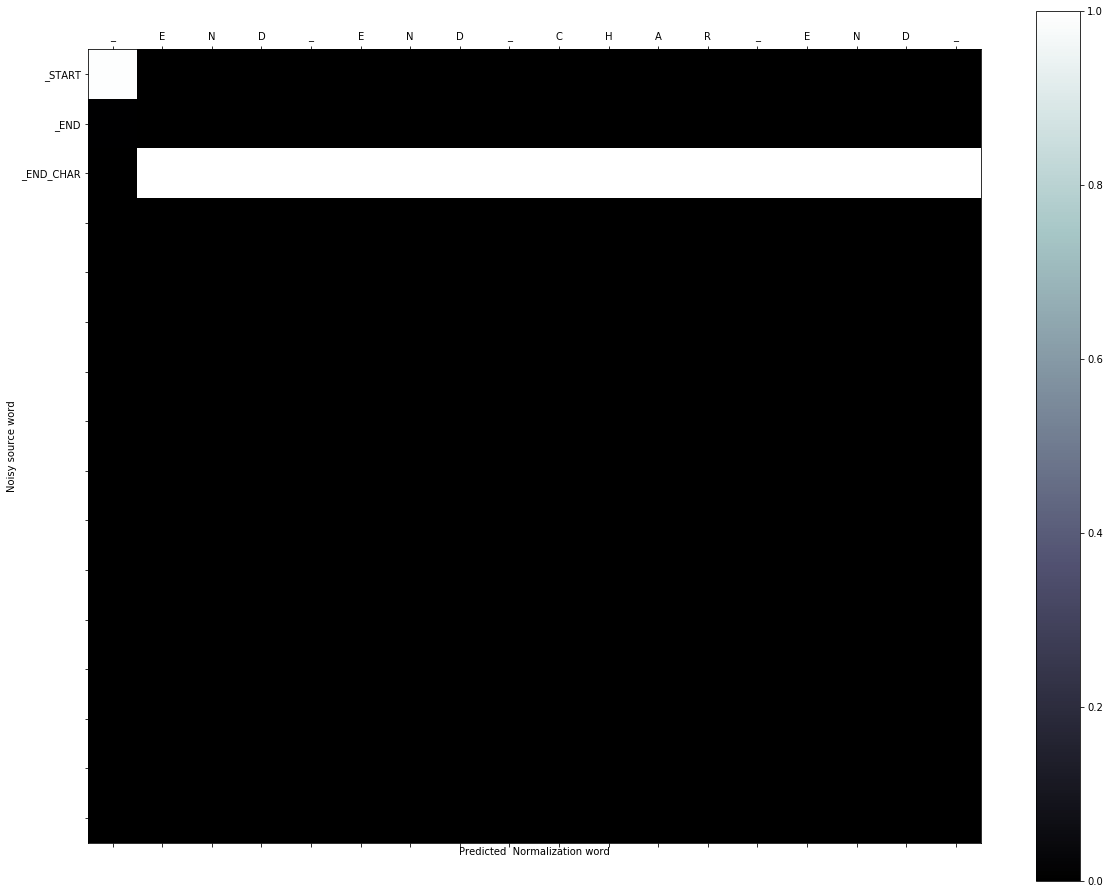

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Trouvez votre prob', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you guys ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you ok ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you ok ?']


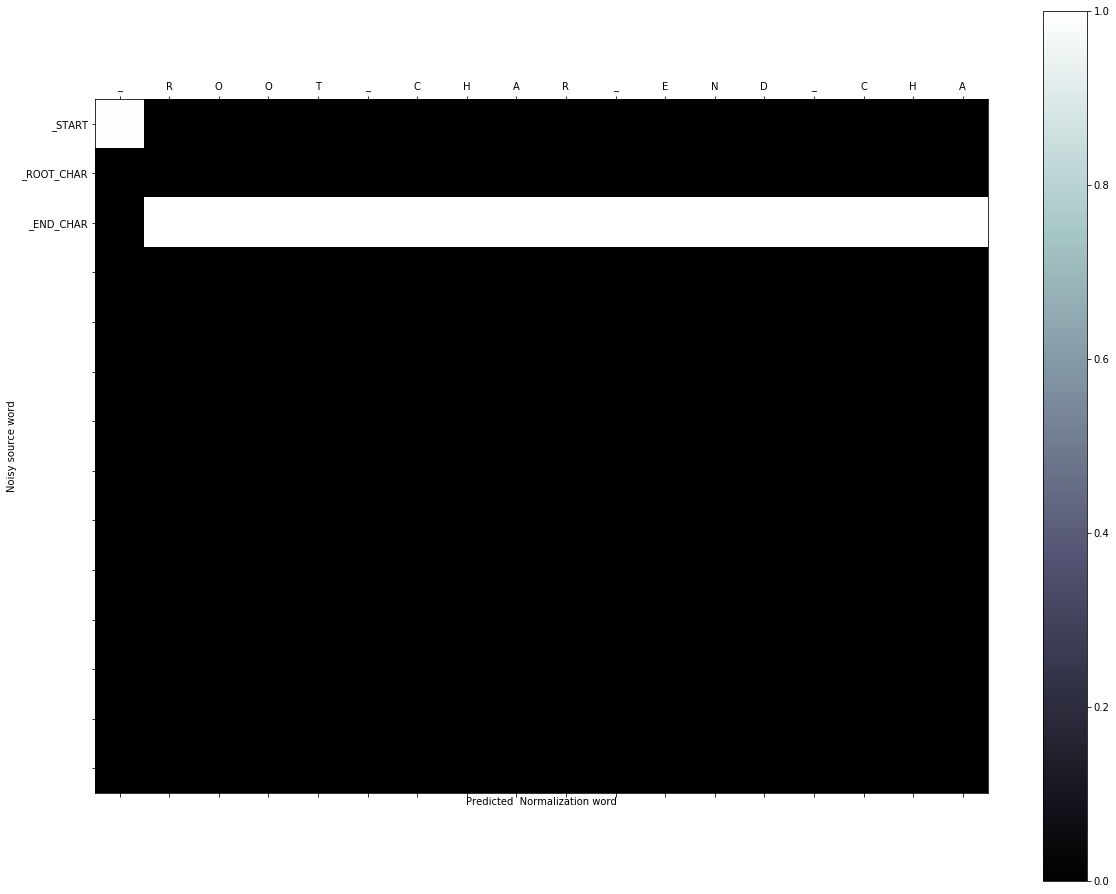

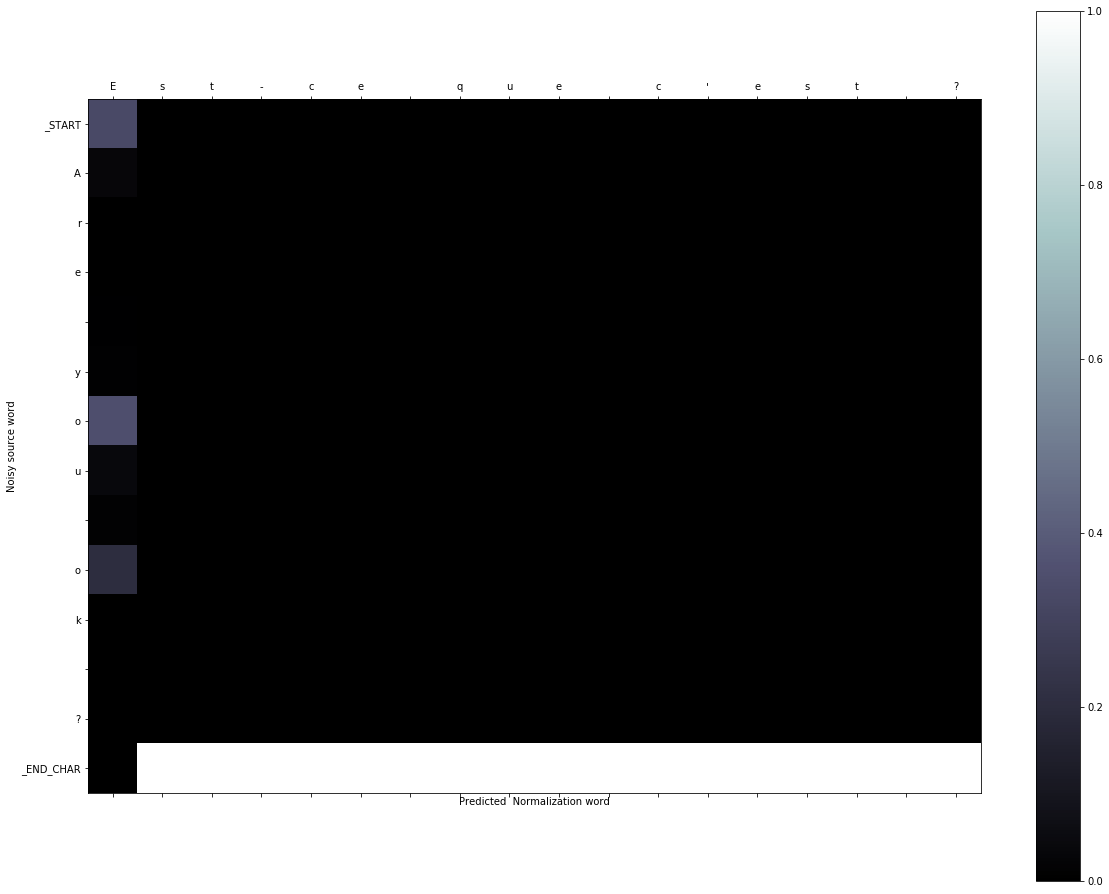

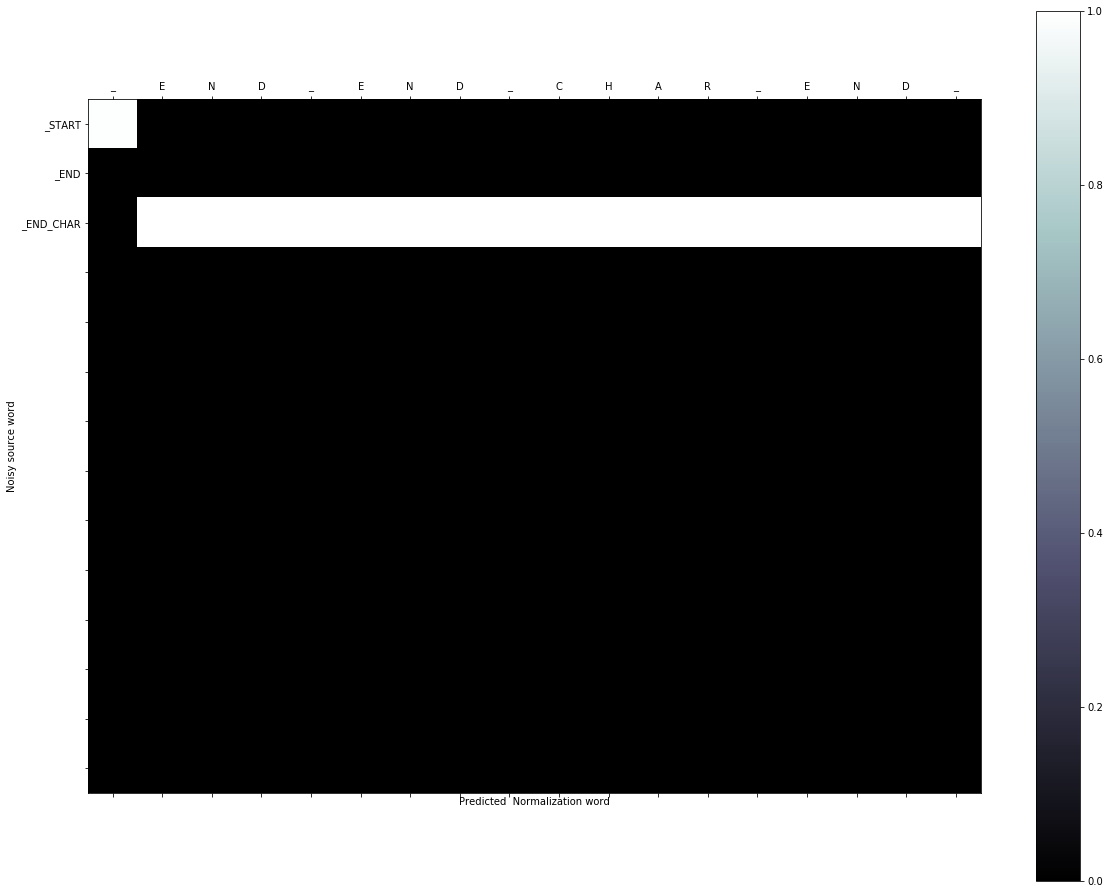

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', "Est-ce que c'est ?", '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you ok ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you french ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you french ?']


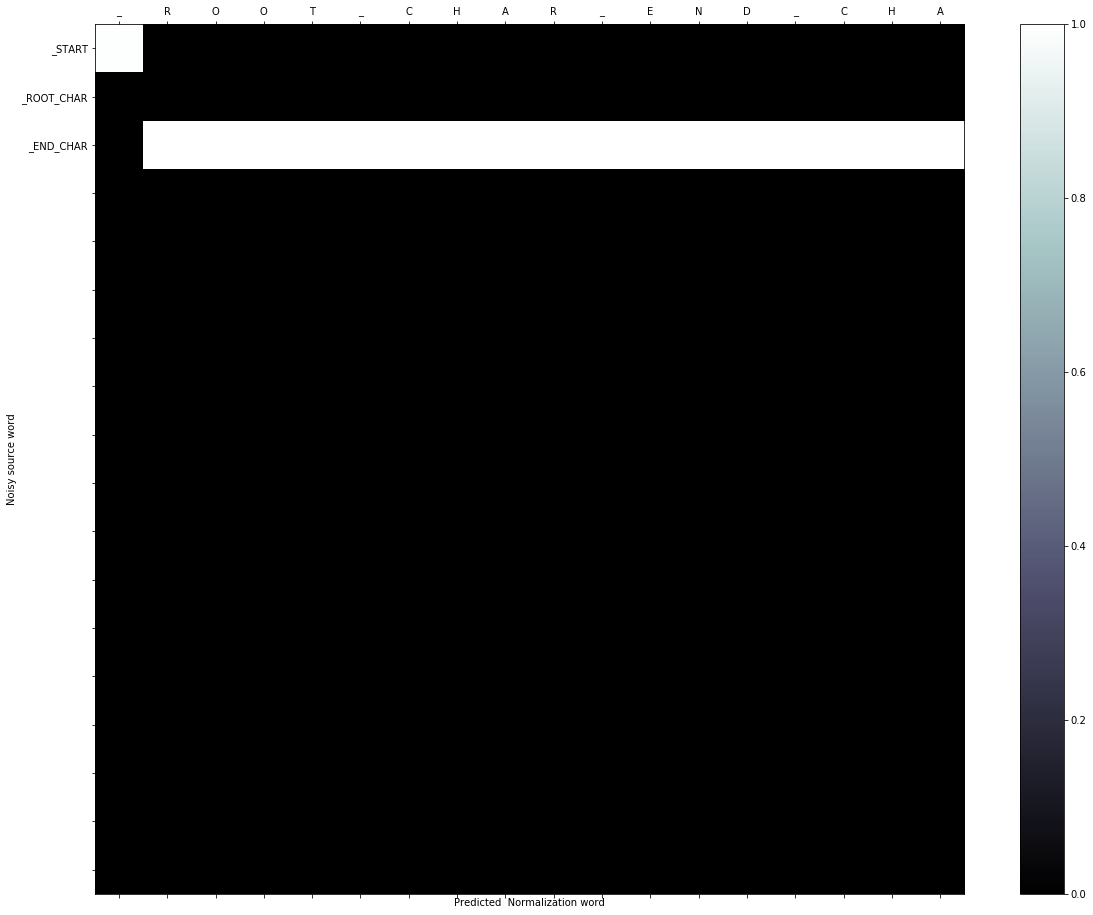

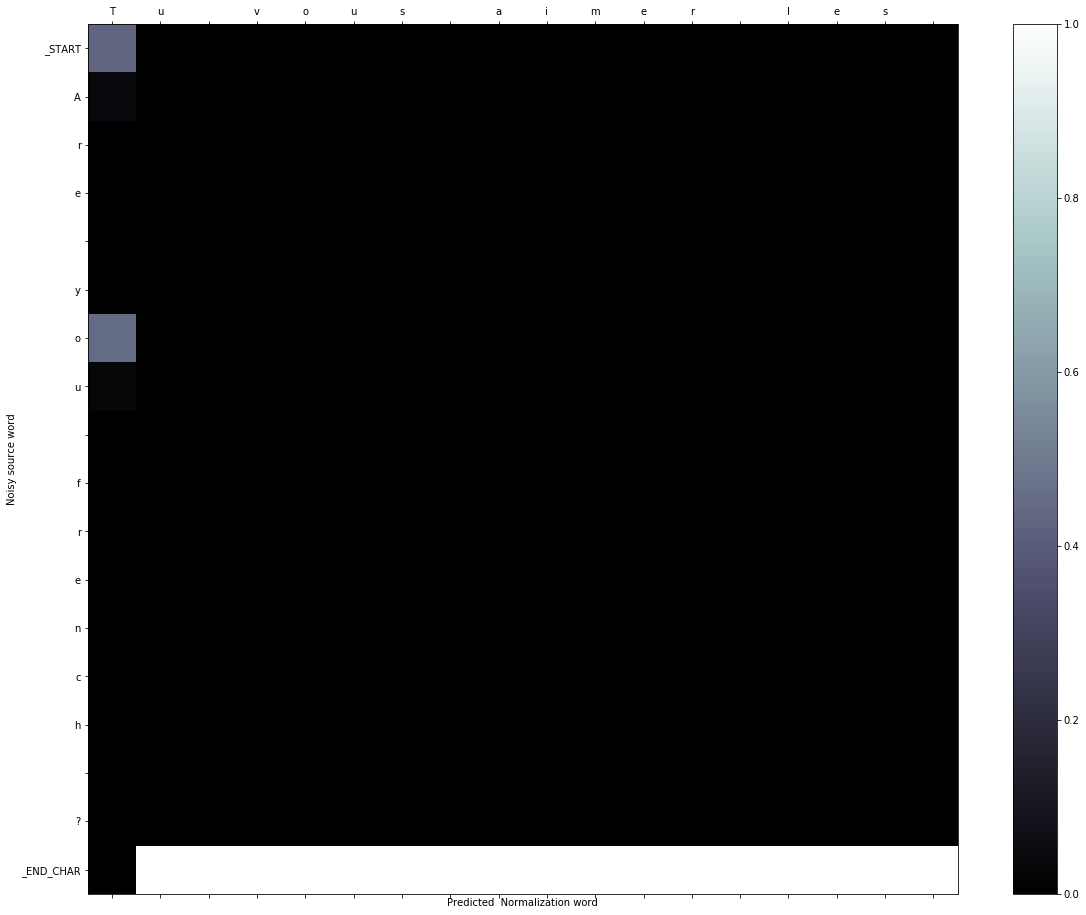

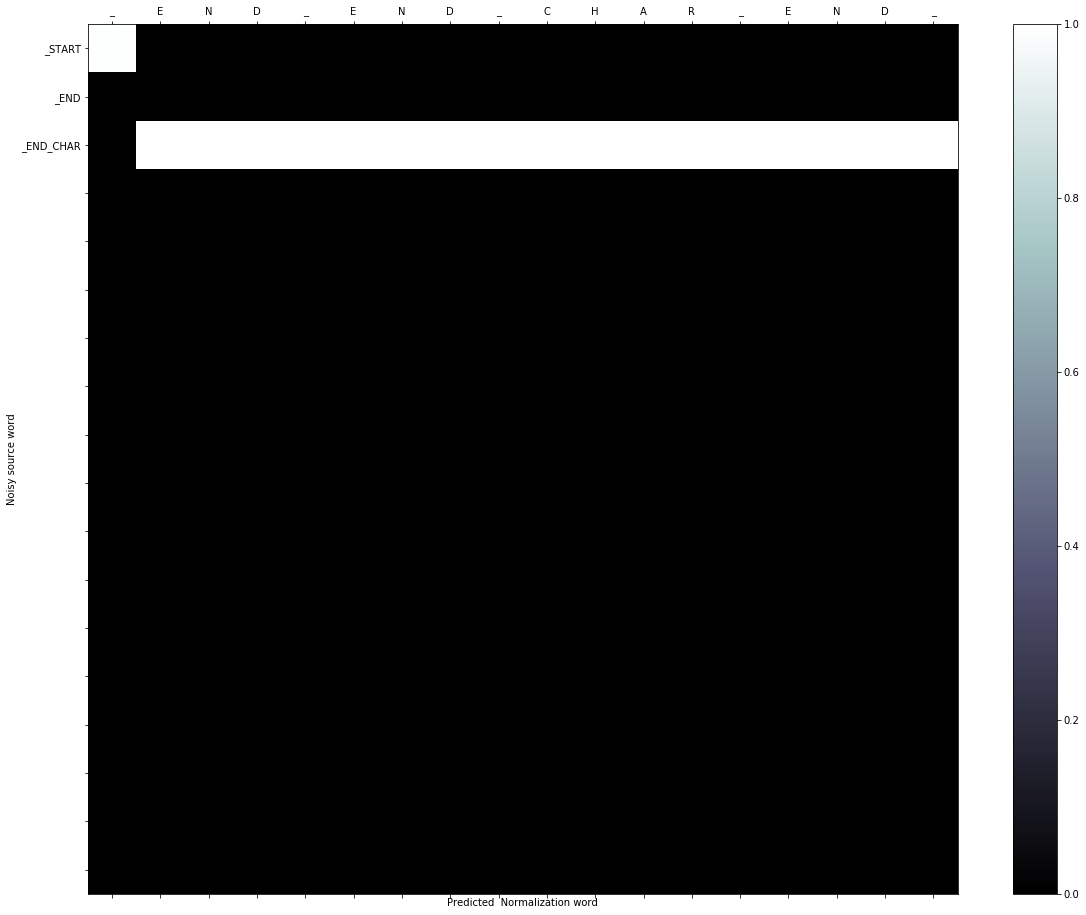

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Tu vous aimer les ', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you french ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you French ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you French ?']


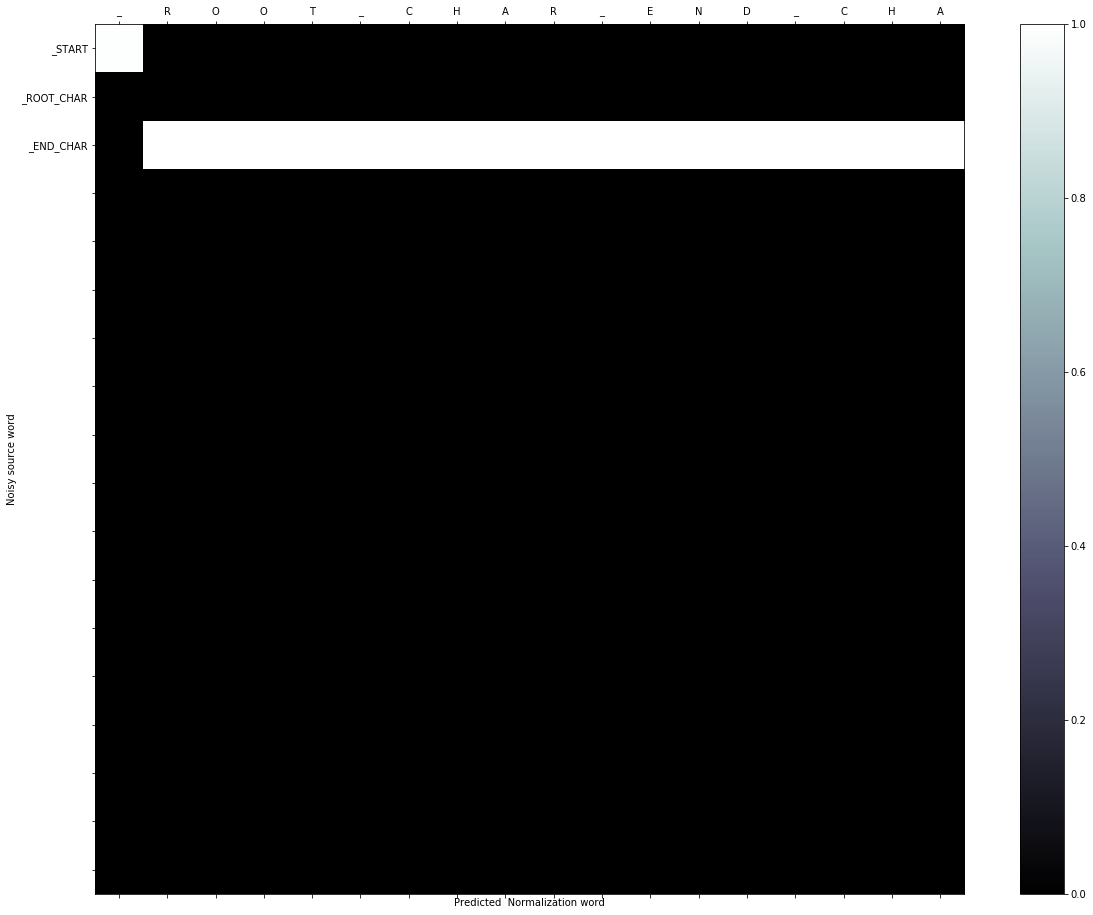

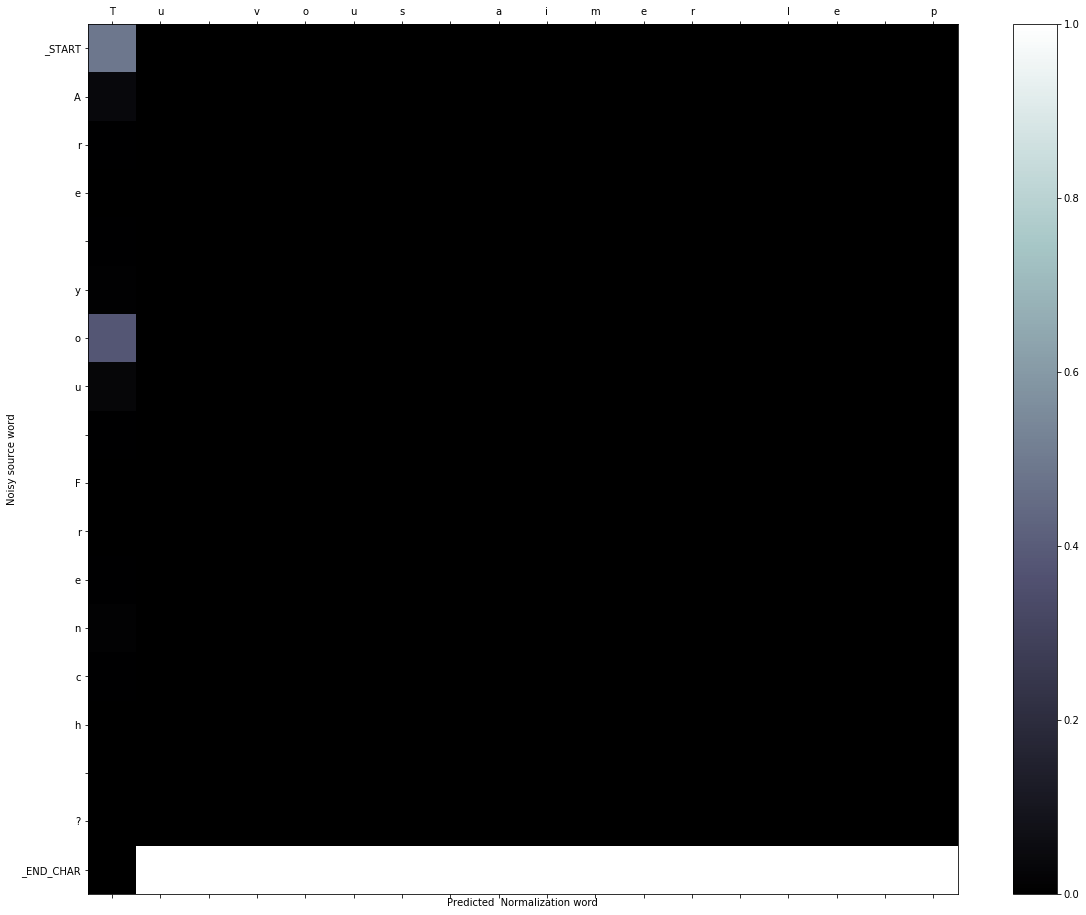

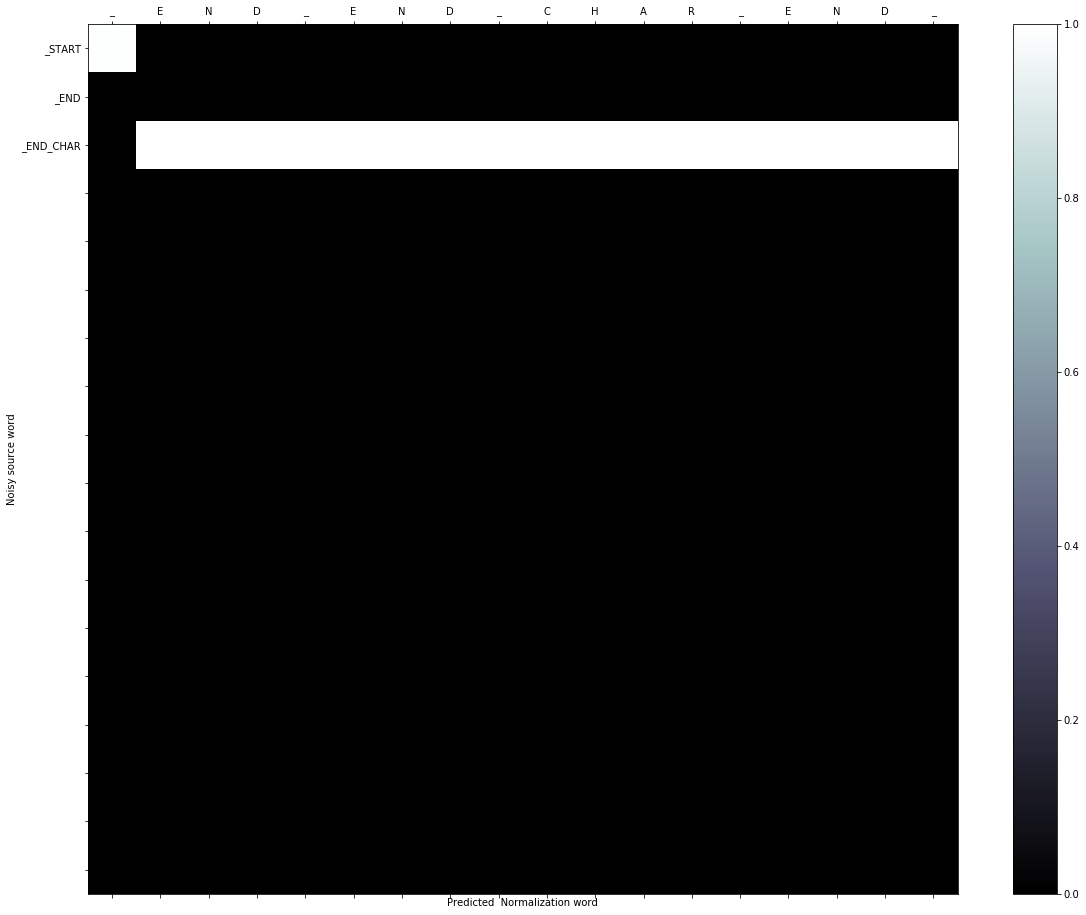

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Tu vous aimer le p', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you French ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Are you Canadian ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Are you Canadian ?']


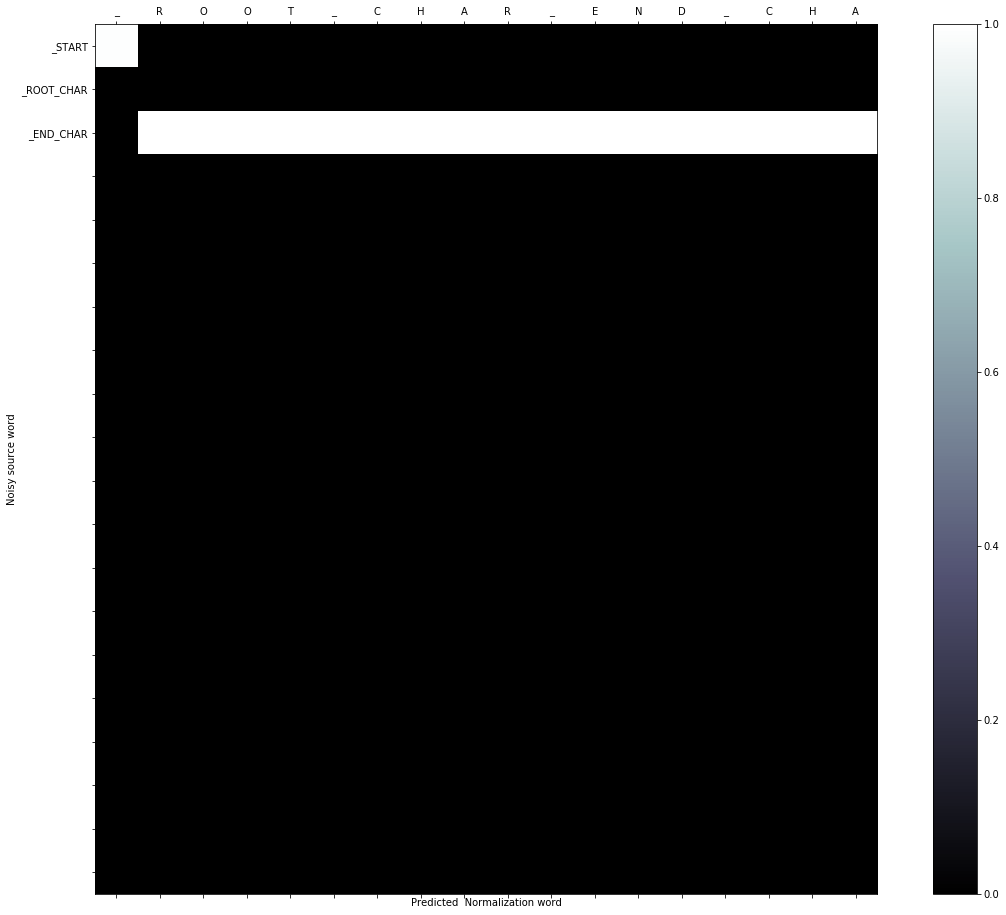

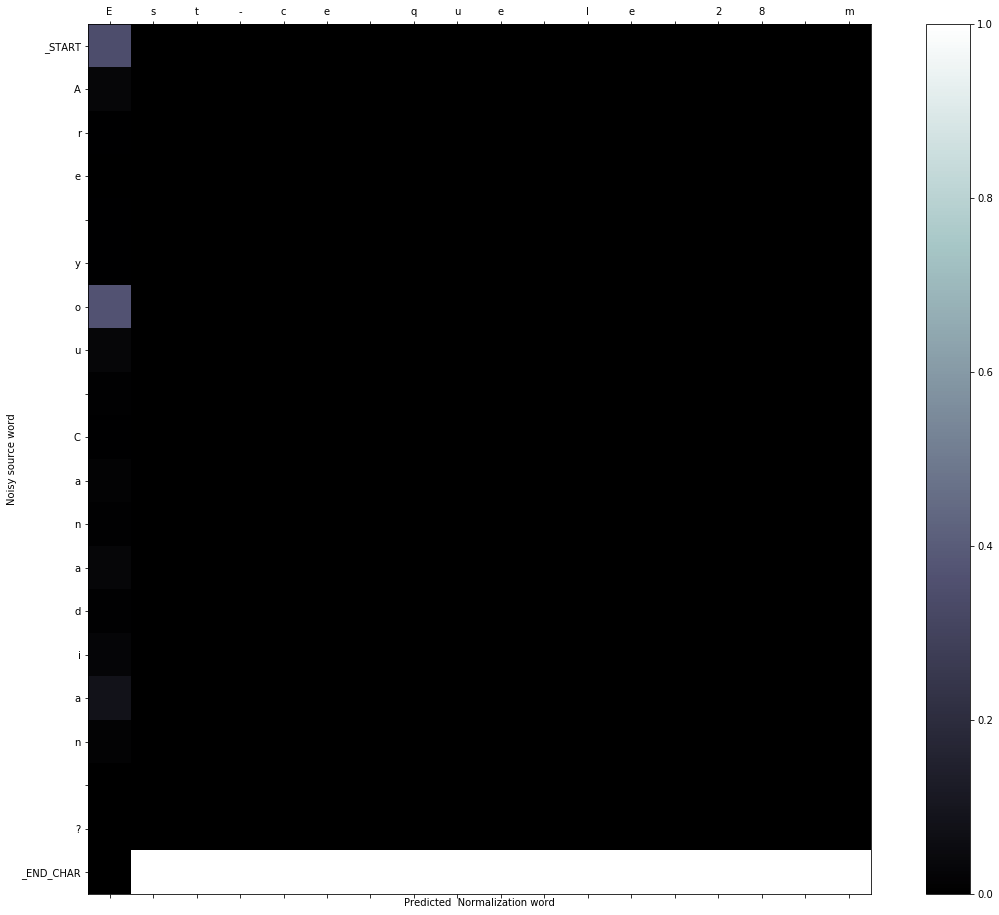

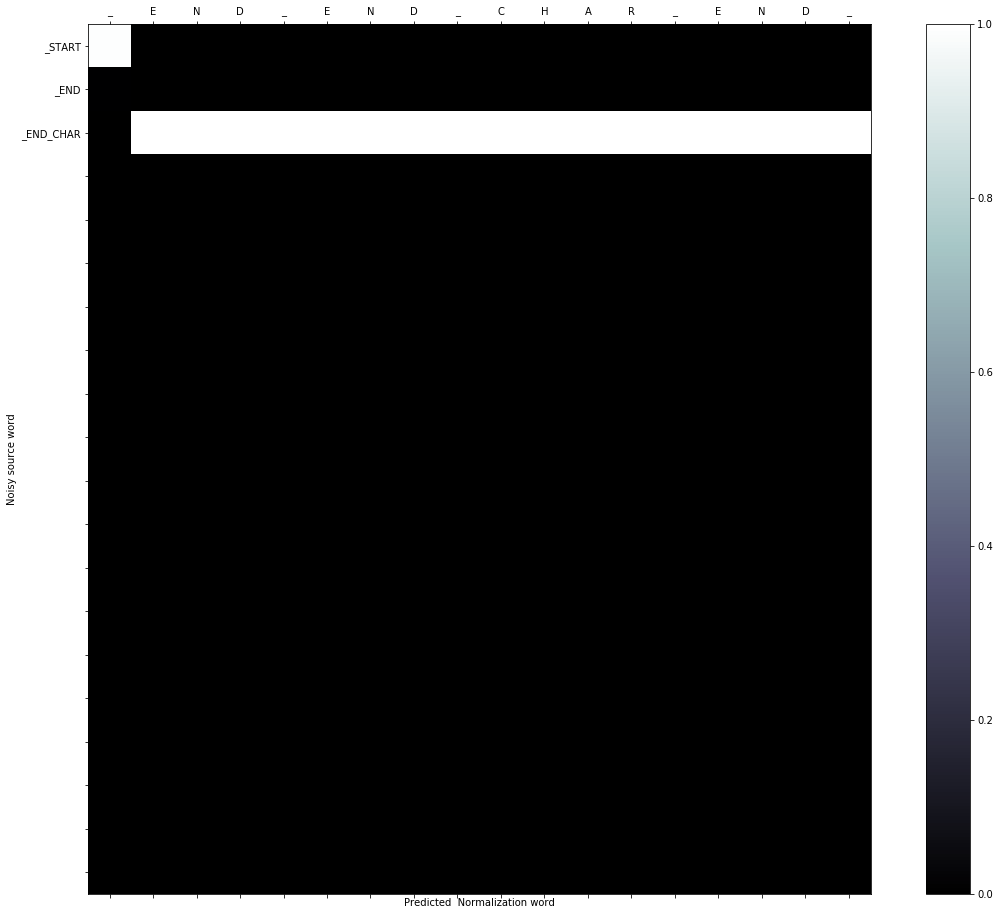

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Est-ce que le 28 m', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAre you Canadian ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Do you like it ?
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Do you like it ?']


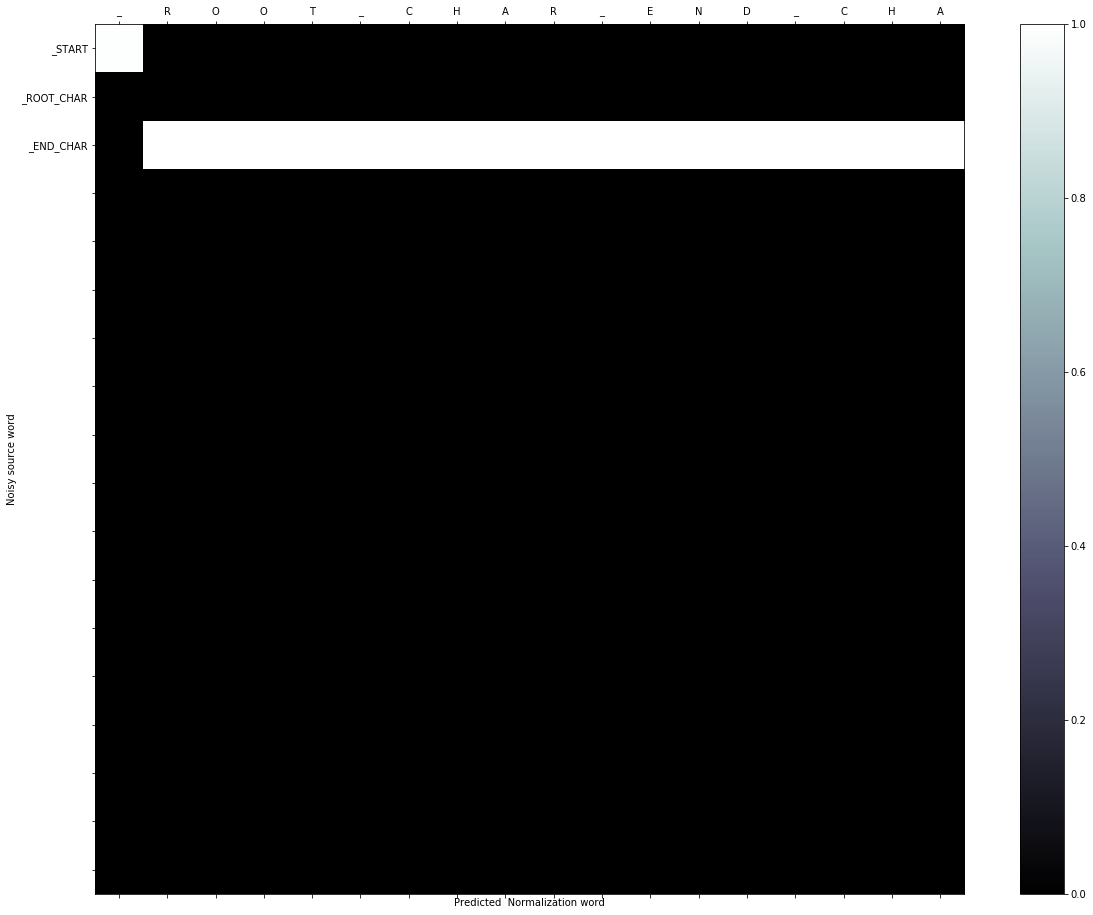

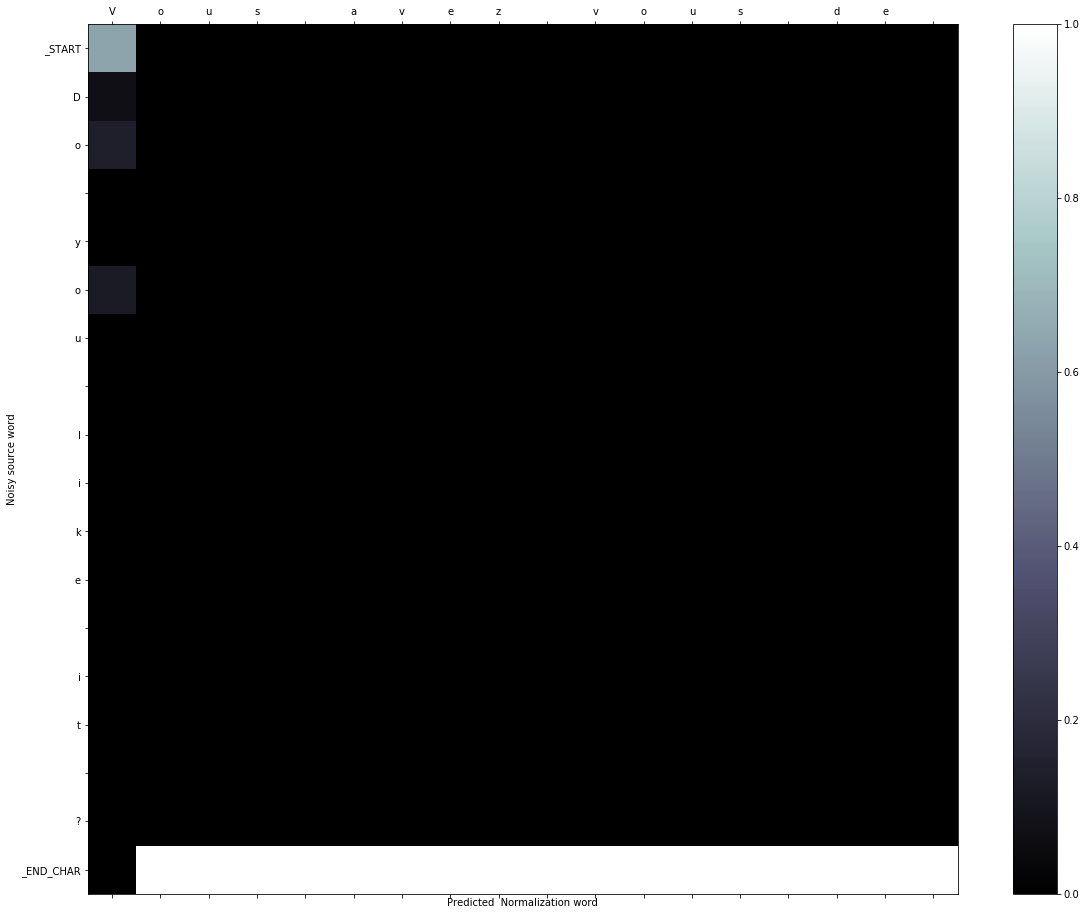

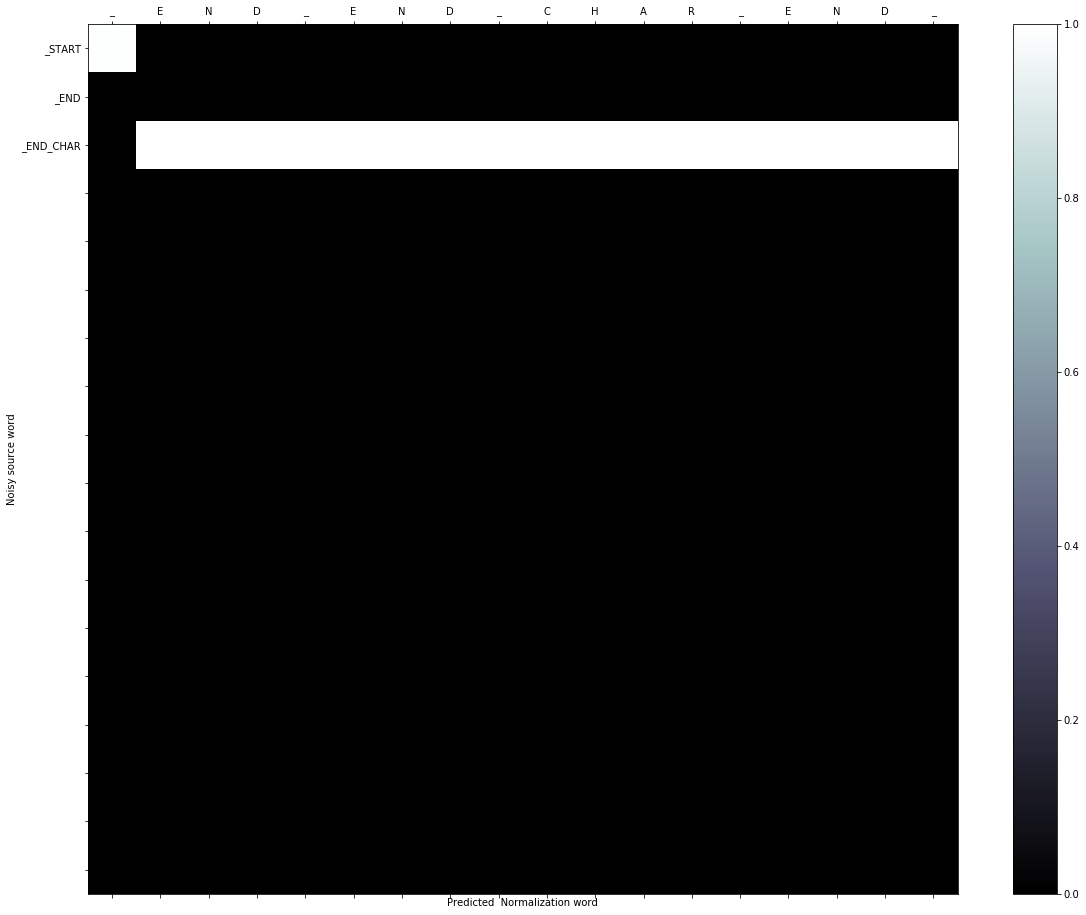

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Vous avez vous de ', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTDo you like it ?_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Am I ok ,
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Am I ok ,']


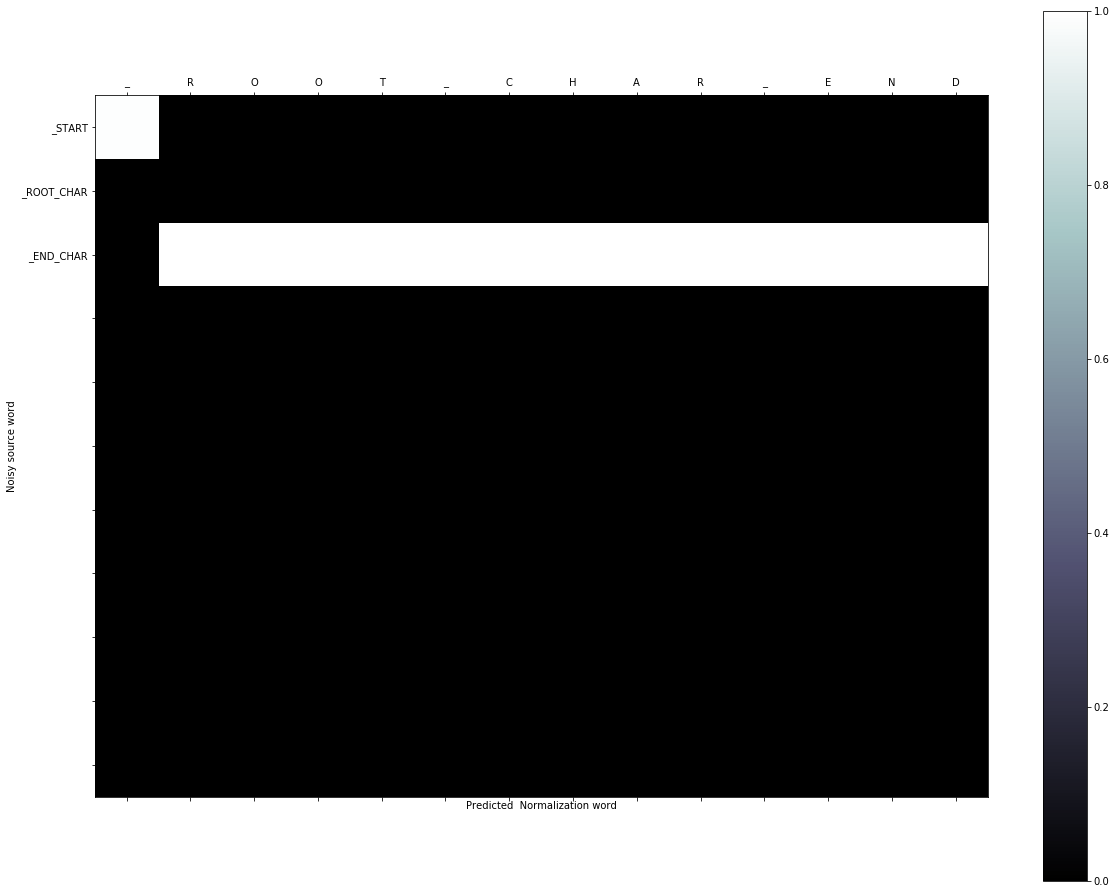

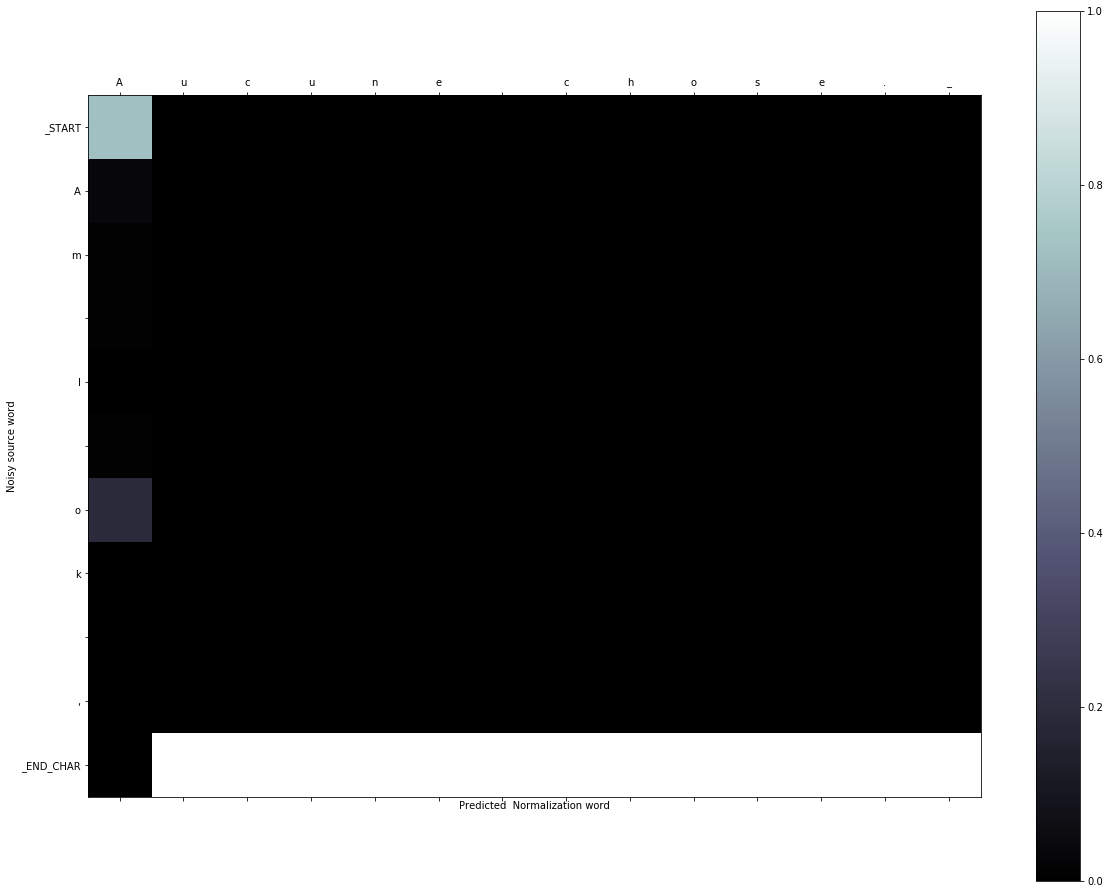

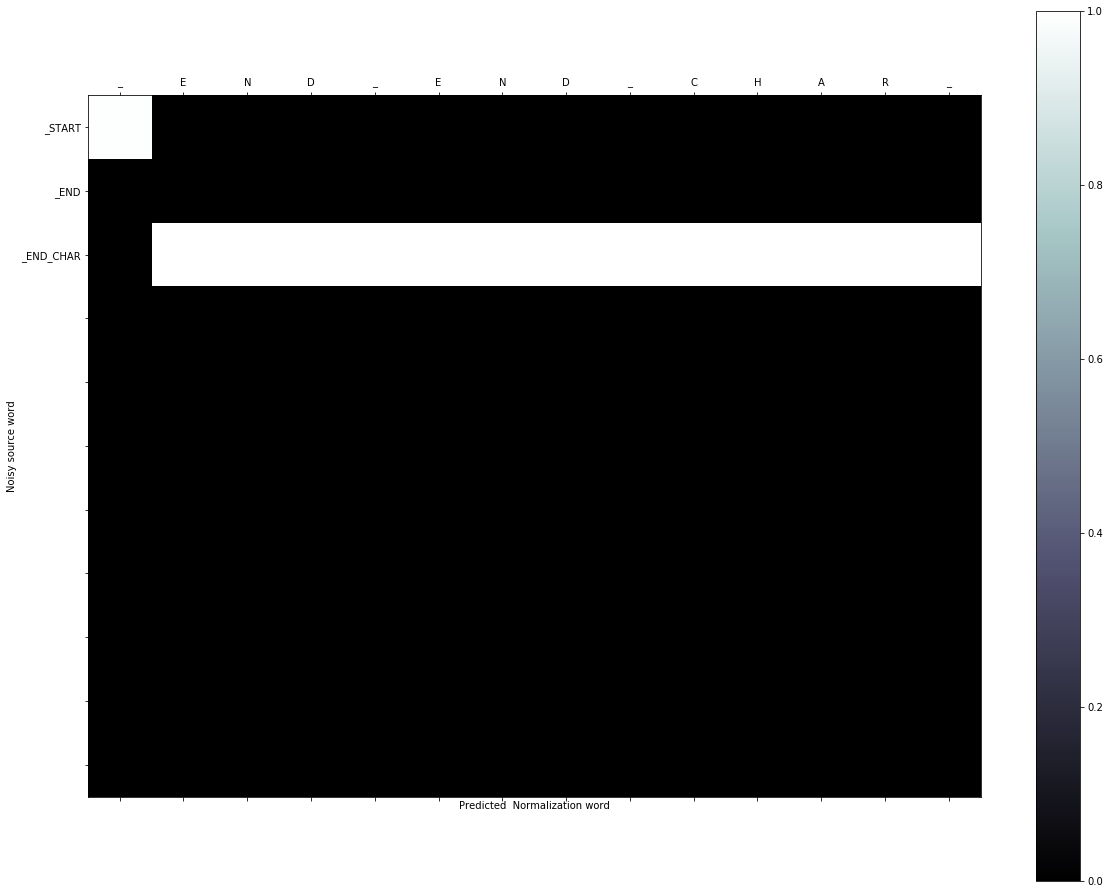

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Aucune chose._END_CHAR', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTAm I ok ,_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    I am
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['I am']


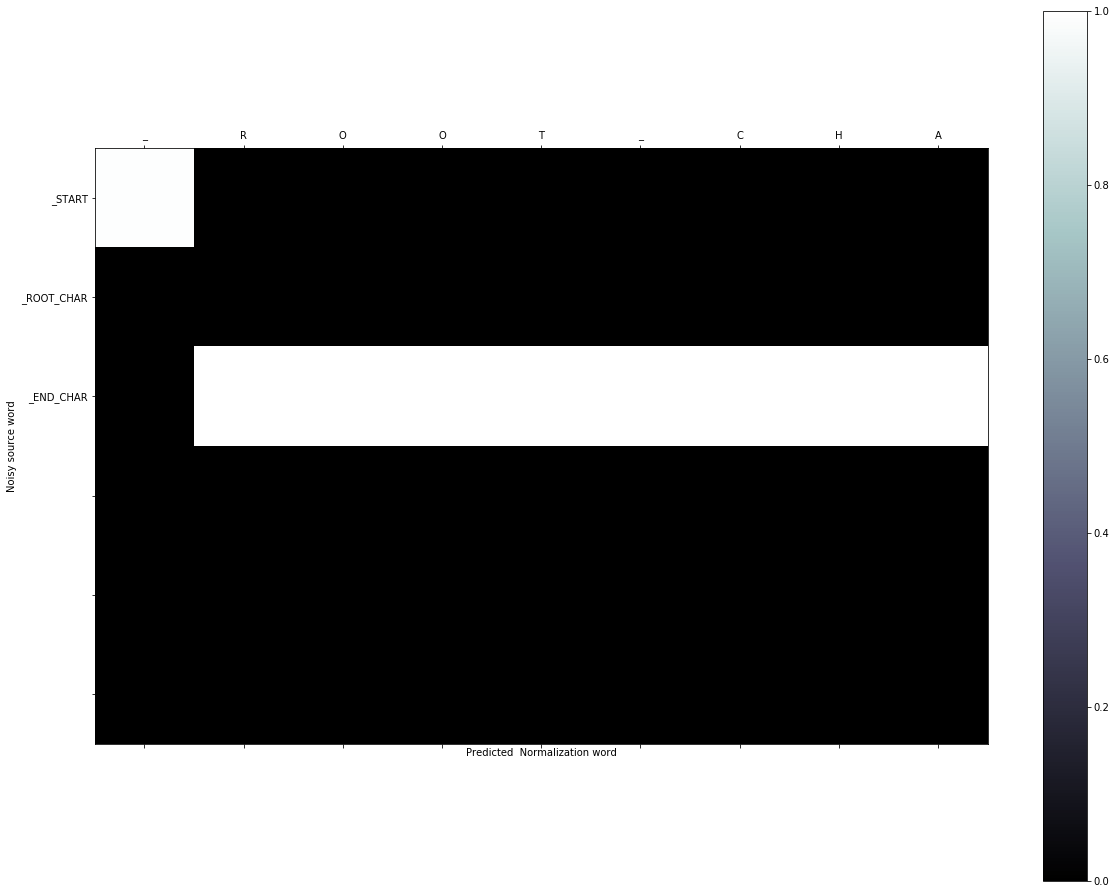

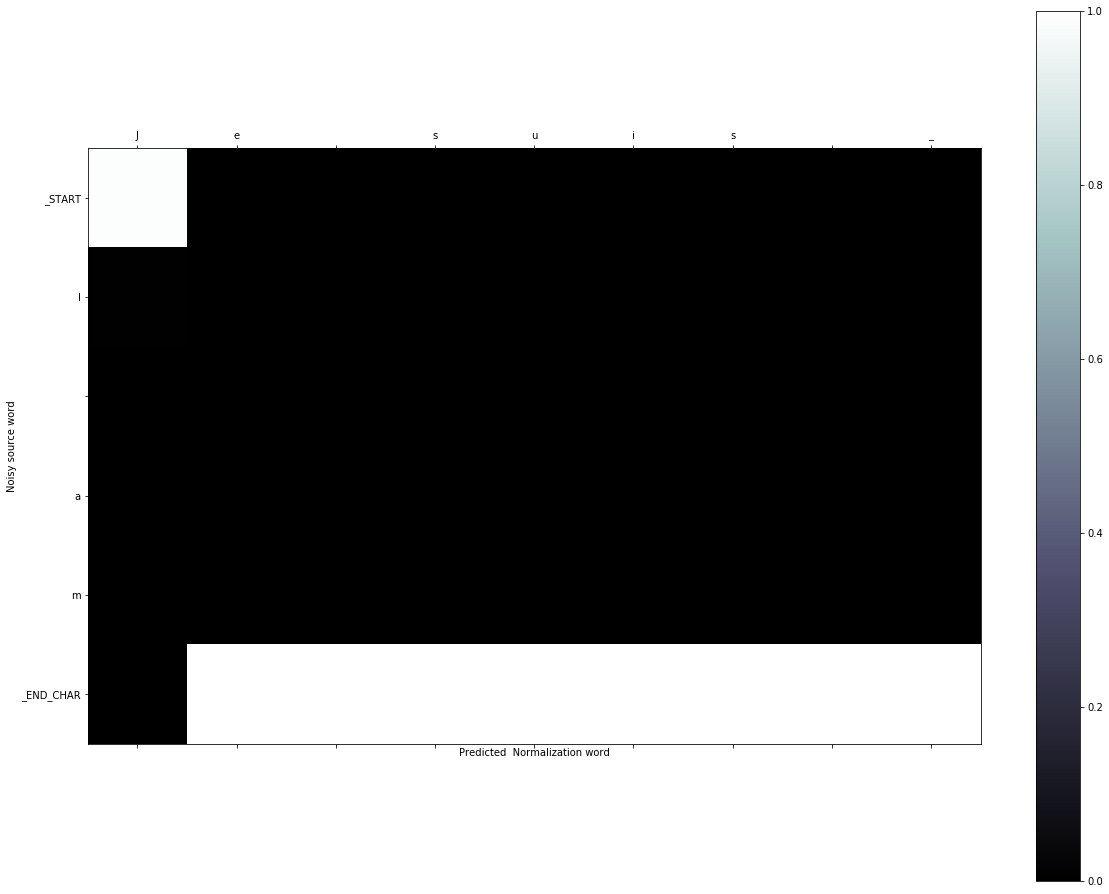

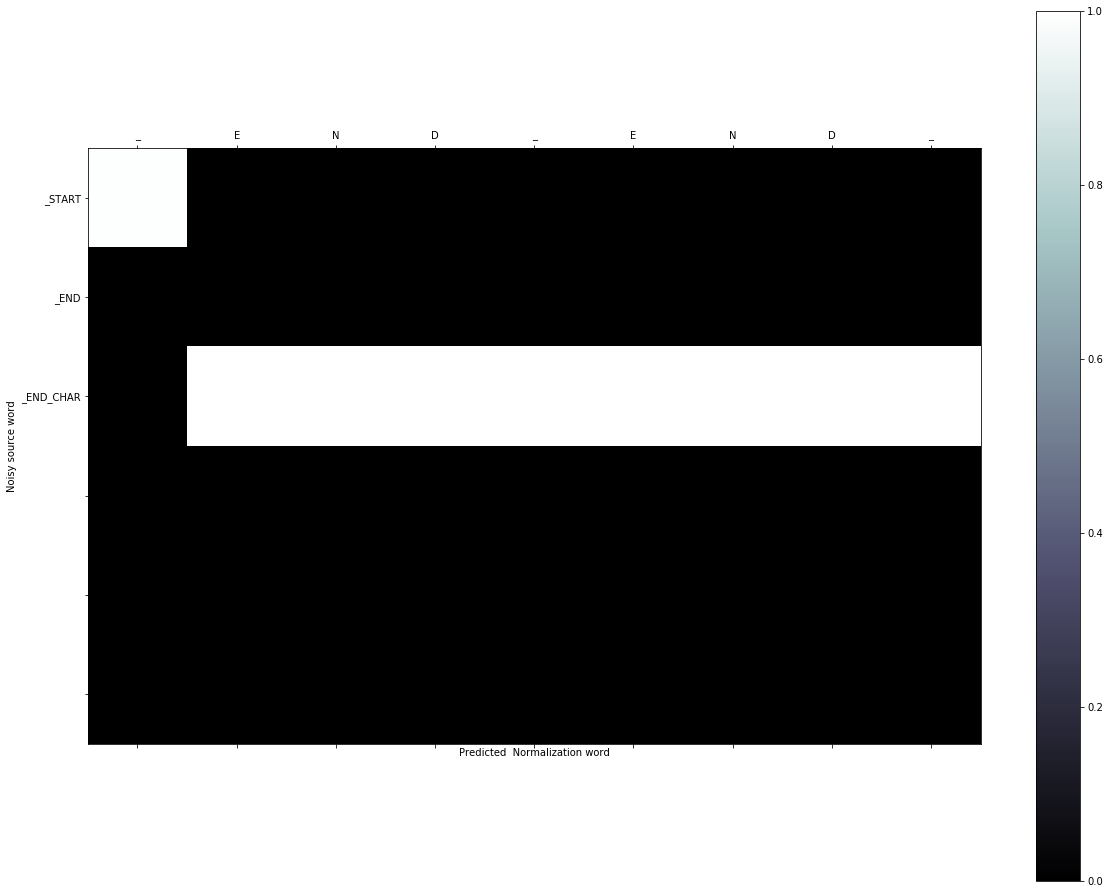

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'Je suis _END_CHAR', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTI am_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent []


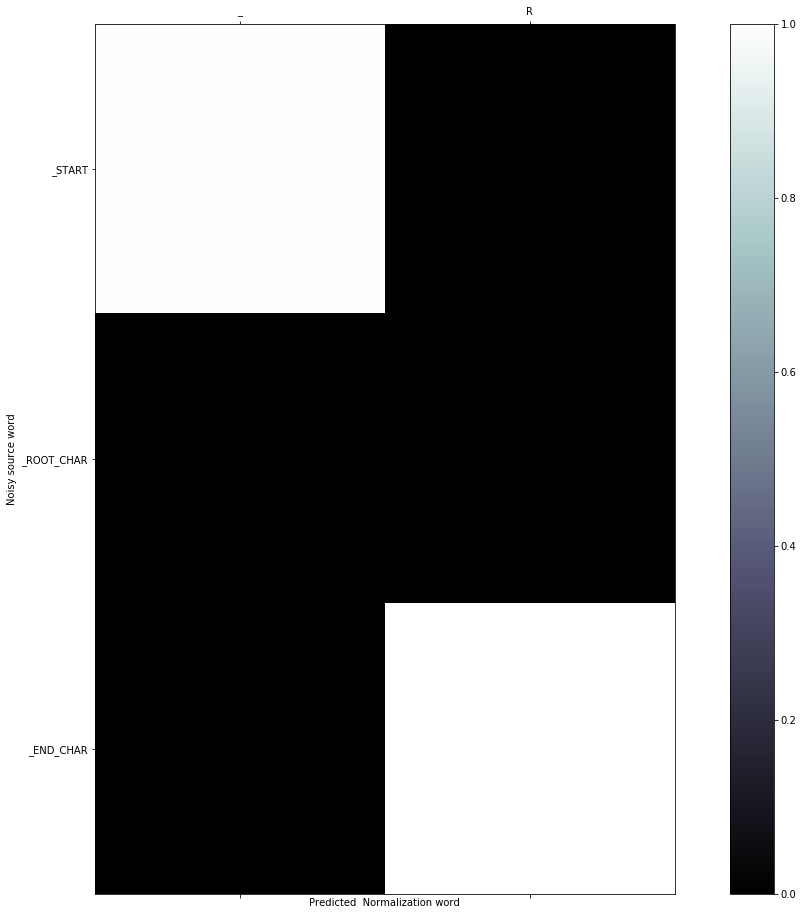

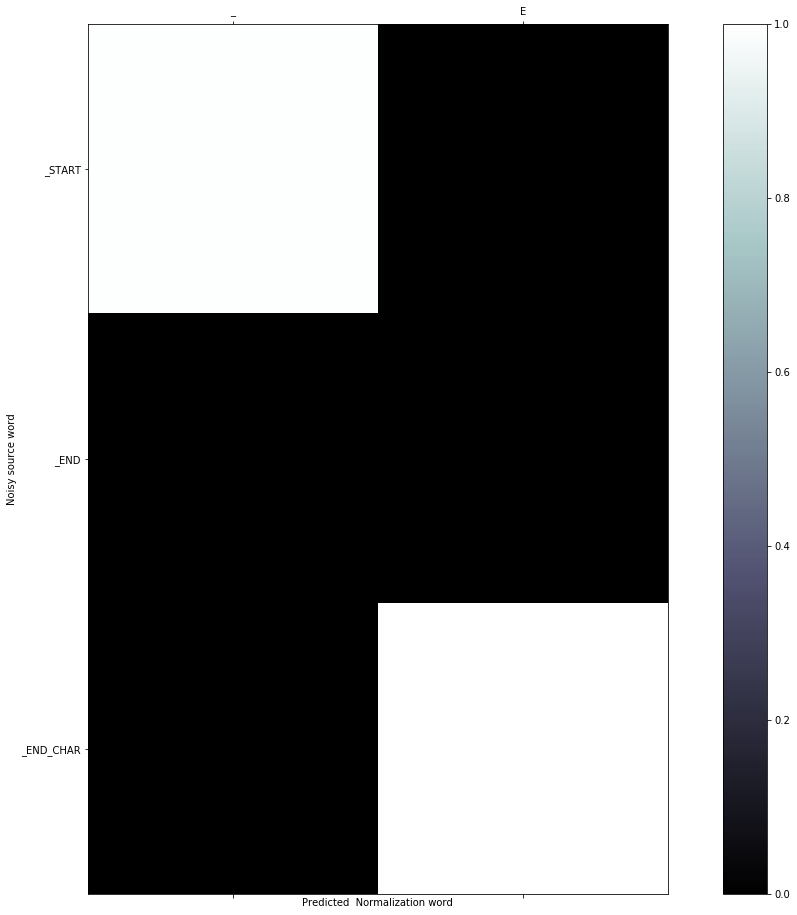

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR', '_END_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 


In [ ]:
for folder_name in list_:
    assert len(list_)>0, "list empty"
    model_full_name = folder_name[:-7]
    print("\n\n--------------------------------Interatcing with new model--------------------------------\n", model_full_name,"\n\n")
    dic_path = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder", "dictionaries")
    model_dir = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder")
    interact(dic_path=dic_path, dir_model=model_dir, model_full_name=model_full_name, 
             debug=False, 
             show_attention=True, save_attention=False,
             extra_arg_specific_label="",
             verbose=0)
    #break

## Comments
- on model 97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e with auxilliary task no attention quite small model
    - interesting case : 
        - my normalized to tomorrow : probably bcause of 2mor --> tommorow 
    - very lame at decoding very short word ? 
- 97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1
    - attention is not static --> but no clear trend
    - interetsintgly with same model but only using sent context : the attention focus on last word all the time "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92" 
    
- "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
    - the best model you played with so far
    - classification does not agree with seq predictiion : most of the classification is NORMED while it performs some change

In [1]:
!open

Usage: open [-e] [-t] [-f] [-W] [-R] [-n] [-g] [-h] [-s <partial SDK name>][-b <bundle identifier>] [-a <application>] [filenames] [--args arguments]
Help: Open opens files from a shell.
      By default, opens each file using the default application for that file.  
      If the file is in the form of a URL, the file will be opened as a URL.
Options: 
      -a                Opens with the specified application.
      -b                Opens with the specified application bundle identifier.
      -e                Opens with TextEdit.
      -t                Opens with default text editor.
      -f                Reads input from standard input and opens with TextEdit.
      -F  --fresh       Launches the app fresh, that is, without restoring windows. Saved persistent state is lost, excluding Untitled documents.
      -R, --reveal      Selects in the Finder instead of opening.
      -W, --wait-apps   Blocks until the used applications are closed (even if they were already running).
  

In [ ]:
"./dat